# Explore metabolism of cancer cells
Corresponds to fig 3 and sfig 3 in draft.

In [1]:
import os
import numpy as np
import anndata as ad
import pandas as pd
import scanpy as sc
from plotnine import *
import shap
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
adata = ad.read_h5ad('../../data/adata_consensus_cell_types.h5ad')

In [3]:
all_functional_and_metab = ['CA9', 'CD98', 'CytC', 'MSH2', 'MCT1', 'ASCT2',
       'LDH', 'STING1', 'GS', 'GLS', 'ATP5A', 'CS', 'PKM2', 'GLUT1', 'MSH6', 'ARG1', 'CPT1A', 'Ki67']

In [4]:
# Group rows by cell type and compute median expression
df = adata.obs.loc[:,all_functional_and_metab]
df["cell_type"] = adata.obs["annotation_consensus"].values
df = df.groupby("cell_type").median().T
df = df.drop("Unclear", axis=1)

/tmp/ipykernel_359020/454442605.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [5]:
from scipy.cluster.hierarchy import linkage, leaves_list
# Perform hierarchical clustering
row_linkage = linkage(df, method='complete')
col_linkage = linkage(df.T, method='complete')

# Get the order of rows and columns
row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

# Scale df values so that each row (abundance for a given marker) is between 0 and 1
df = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis = 1)

# Reorder the DataFrame
df_reordered = df.iloc[row_order, :].iloc[:, col_order]

# Reorder the DataFrame
df_reordered = df.iloc[row_order, :].iloc[:, col_order]

# Melt the DataFrame for plotnine
df_melted = df_reordered.melt(ignore_index=False).reset_index()

# Update the levels of the categorical variables to reflect the new order
df_melted["index"] = pd.Categorical(df_melted["index"], categories=df_reordered.index, ordered=True)
df_melted["cell_type"] = pd.Categorical(df_melted["cell_type"], categories=df_reordered.columns.to_list(), ordered=True)

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3.2 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/heatmap_all_markers_scaled.png
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3.2 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/heatmap_all_markers_scaled.pdf


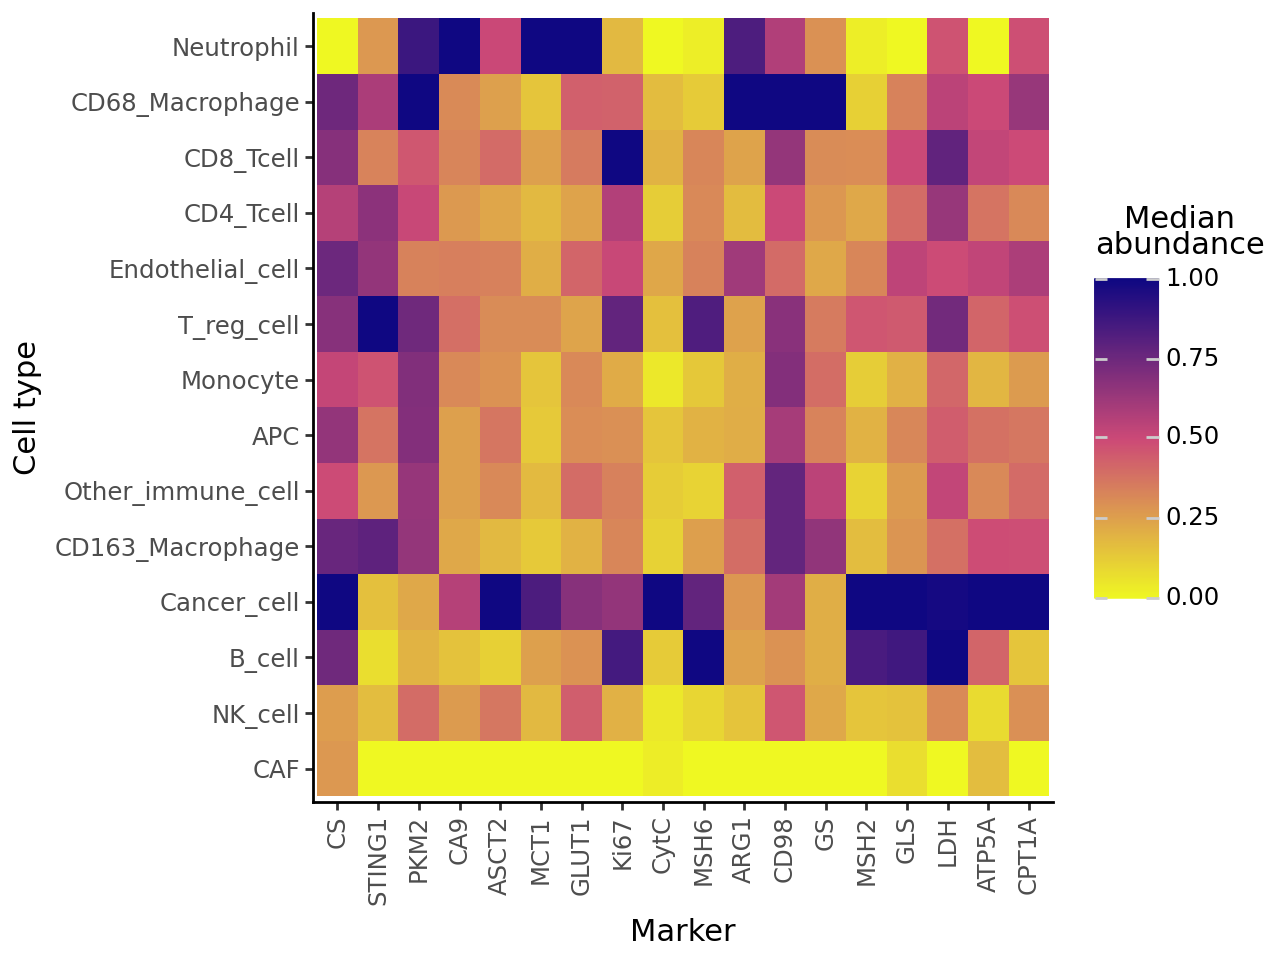

In [6]:
# Display as heatmap
gp = (
    ggplot(df_melted, aes(x="index", y="cell_type")) 
    + geom_tile(aes(fill="value")) 
    + theme_classic() 
    + theme(axis_text_x=element_text(angle=90)) 
    + labs(y="Cell type", x="Marker", fill="Median\nabundance") 
    # + coord_equal()
    # Use reverted plasma color palette
    + scale_fill_gradientn(colors = ["#EFF822", "#CC4977","#0F0782"])
)
ggsave(gp, "../../figures/fig3/heatmap_all_markers_scaled.png", width = 6, height = 3.2)
ggsave(gp, "../../figures/fig3/heatmap_all_markers_scaled.pdf", width = 6, height = 3.2)
gp

In [7]:
# Repeat the analysis for each tumor stage
clini = pd.read_csv("../../data/summary_clinical_data_modified.csv", index_col=2)
adata.obs = adata.obs.merge(clini, left_on="fov", right_index=True, how="left")

In [8]:
adata.obs["Stage"] = adata.obs["pT group"]
# # E1 and E2 samples are annotated 'SCT' while E3 and E4 are 'Colon-no.'
adata.obs.loc[adata.obs.fov.str.contains("E4"), "Stage"] = "Colon-no."
adata.obs.loc[adata.obs.fov.str.contains("E3"), "Stage"] = "Colon-no."
adata.obs.loc[adata.obs.fov.str.contains("E2"), "Stage"] = "SCT"
adata.obs.loc[adata.obs.fov.str.contains("E1"), "Stage"] = "SCT"

In [9]:
# Export for later spatial analyses
adata.obs.to_csv("../../data/cell_table_with_types_stage.csv")

/tmp/ipykernel_359020/258105503.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_359020/258105503.py:36: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


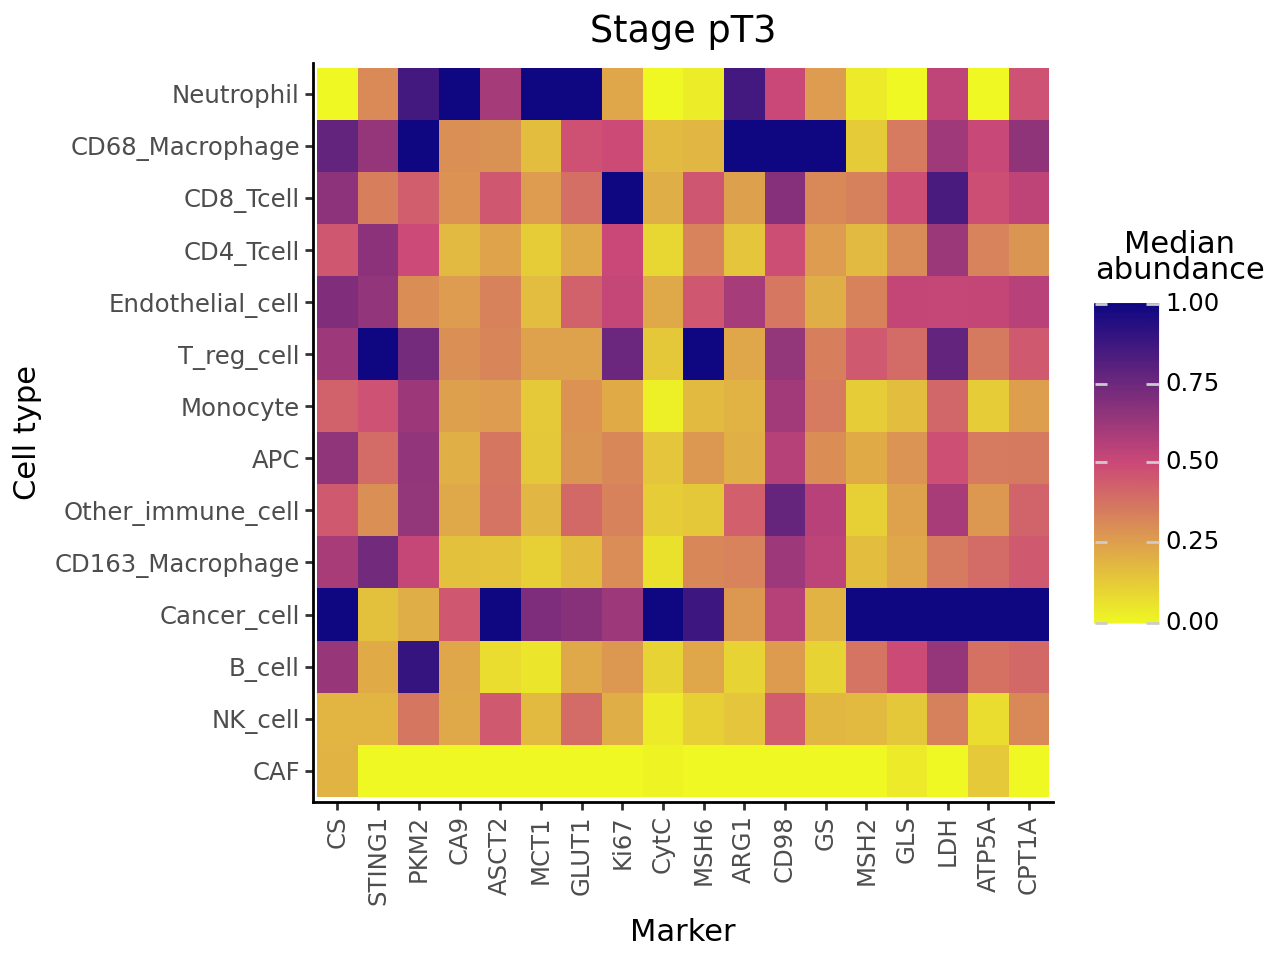

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3.2 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/heatmap_all_markers_scaled_stage_pT3.png


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3.2 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/heatmap_all_markers_scaled_stage_pT3.pdf
/tmp/ipykernel_359020/258105503.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_359020/258105503.py:36: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


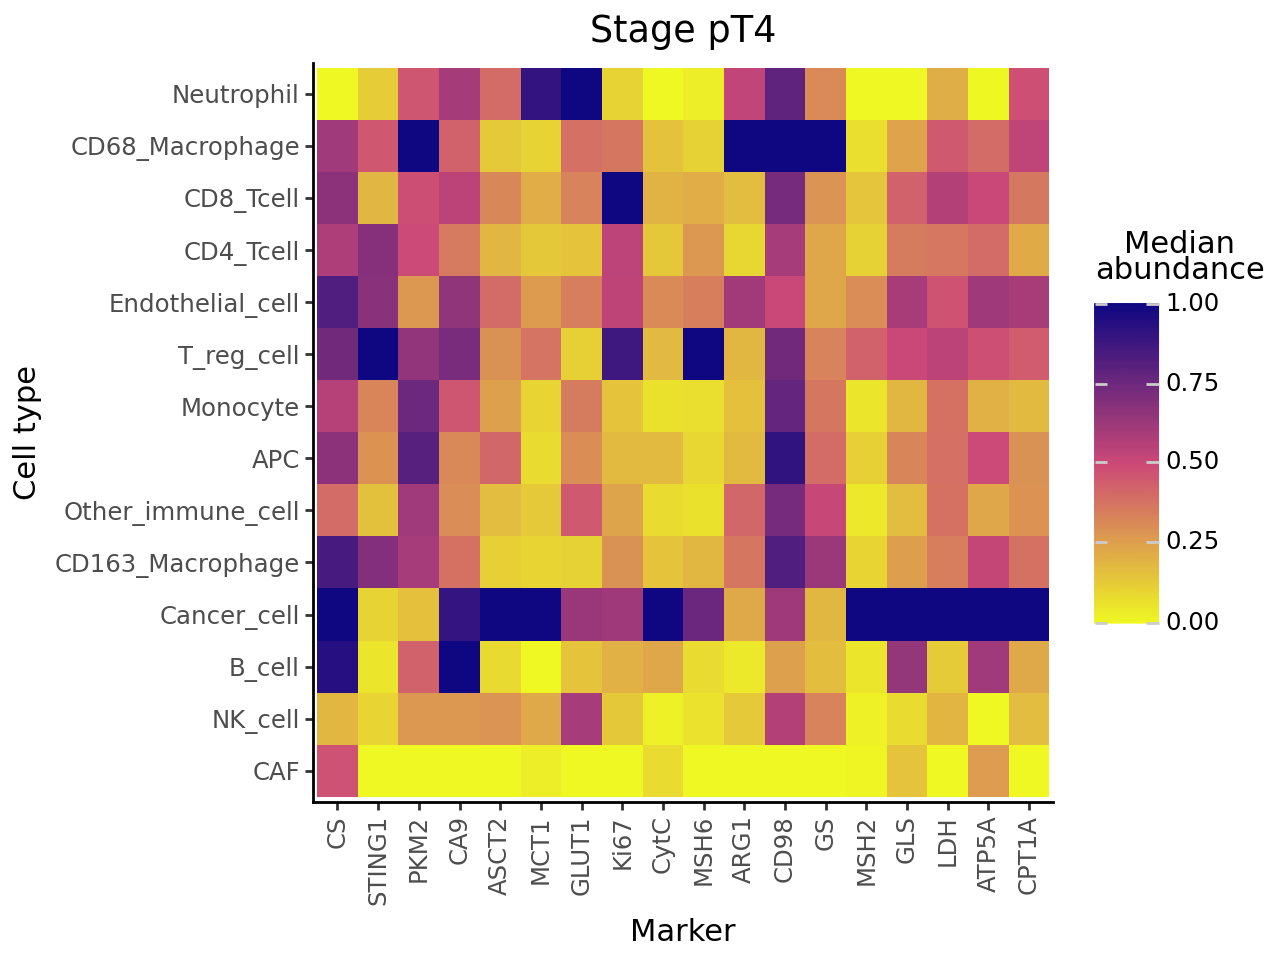

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3.2 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/heatmap_all_markers_scaled_stage_pT4.png


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3.2 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/heatmap_all_markers_scaled_stage_pT4.pdf
/tmp/ipykernel_359020/258105503.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_359020/258105503.py:36: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


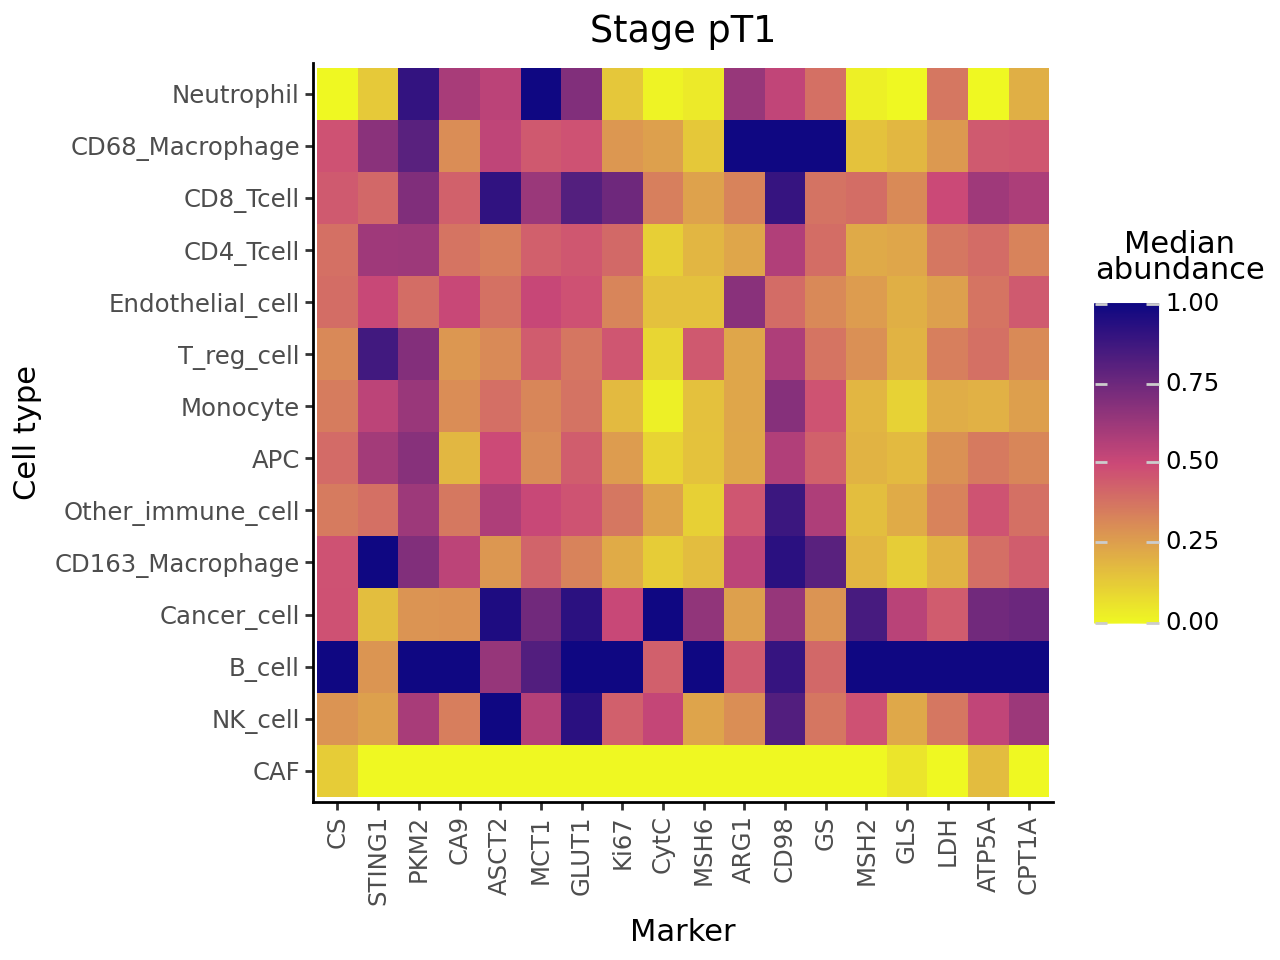

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3.2 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/heatmap_all_markers_scaled_stage_pT1.png


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3.2 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/heatmap_all_markers_scaled_stage_pT1.pdf
/tmp/ipykernel_359020/258105503.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_359020/258105503.py:36: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


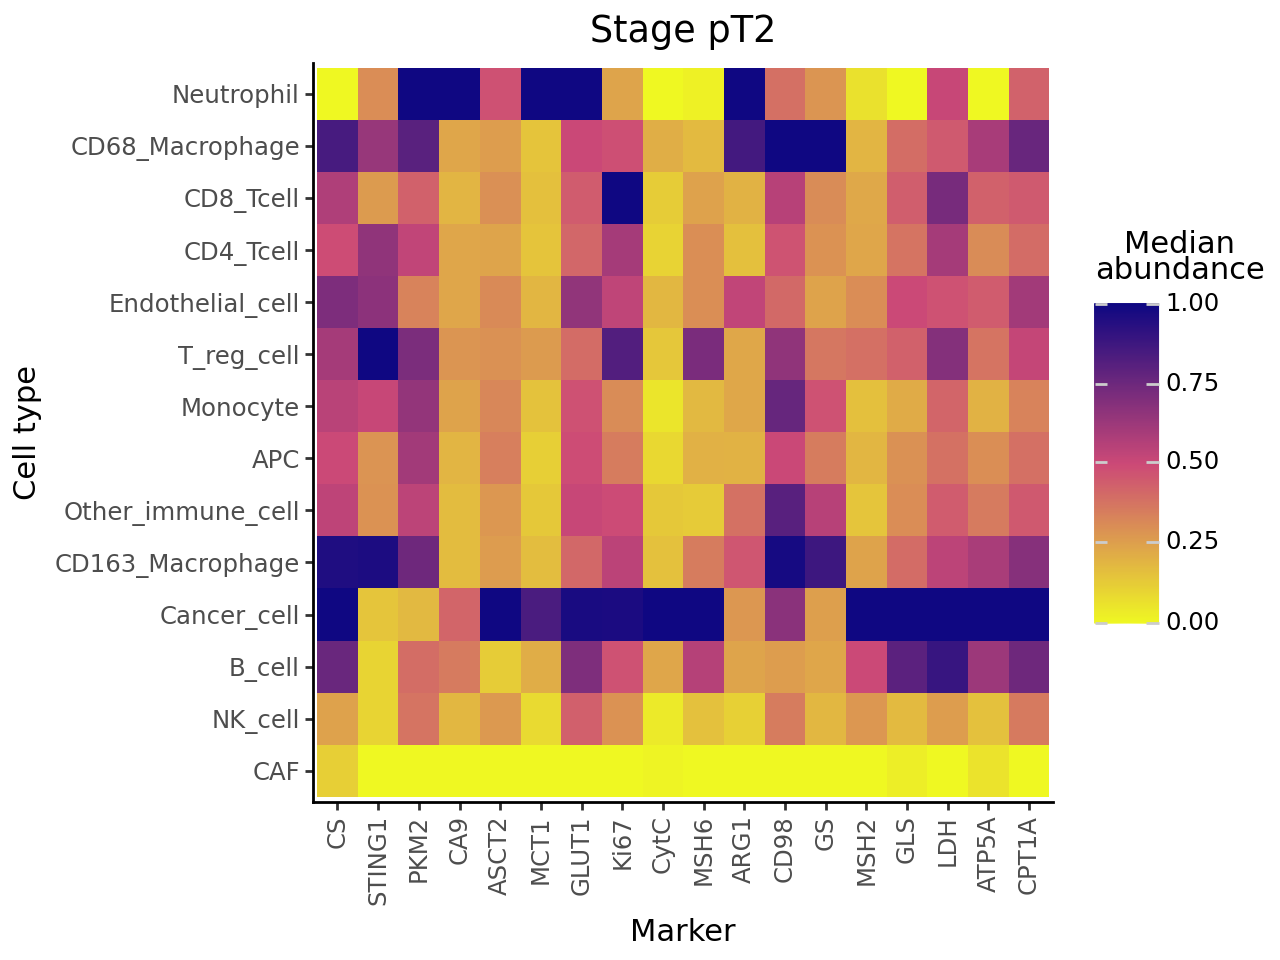

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3.2 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/heatmap_all_markers_scaled_stage_pT2.png


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3.2 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/heatmap_all_markers_scaled_stage_pT2.pdf
/tmp/ipykernel_359020/258105503.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_359020/258105503.py:36: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


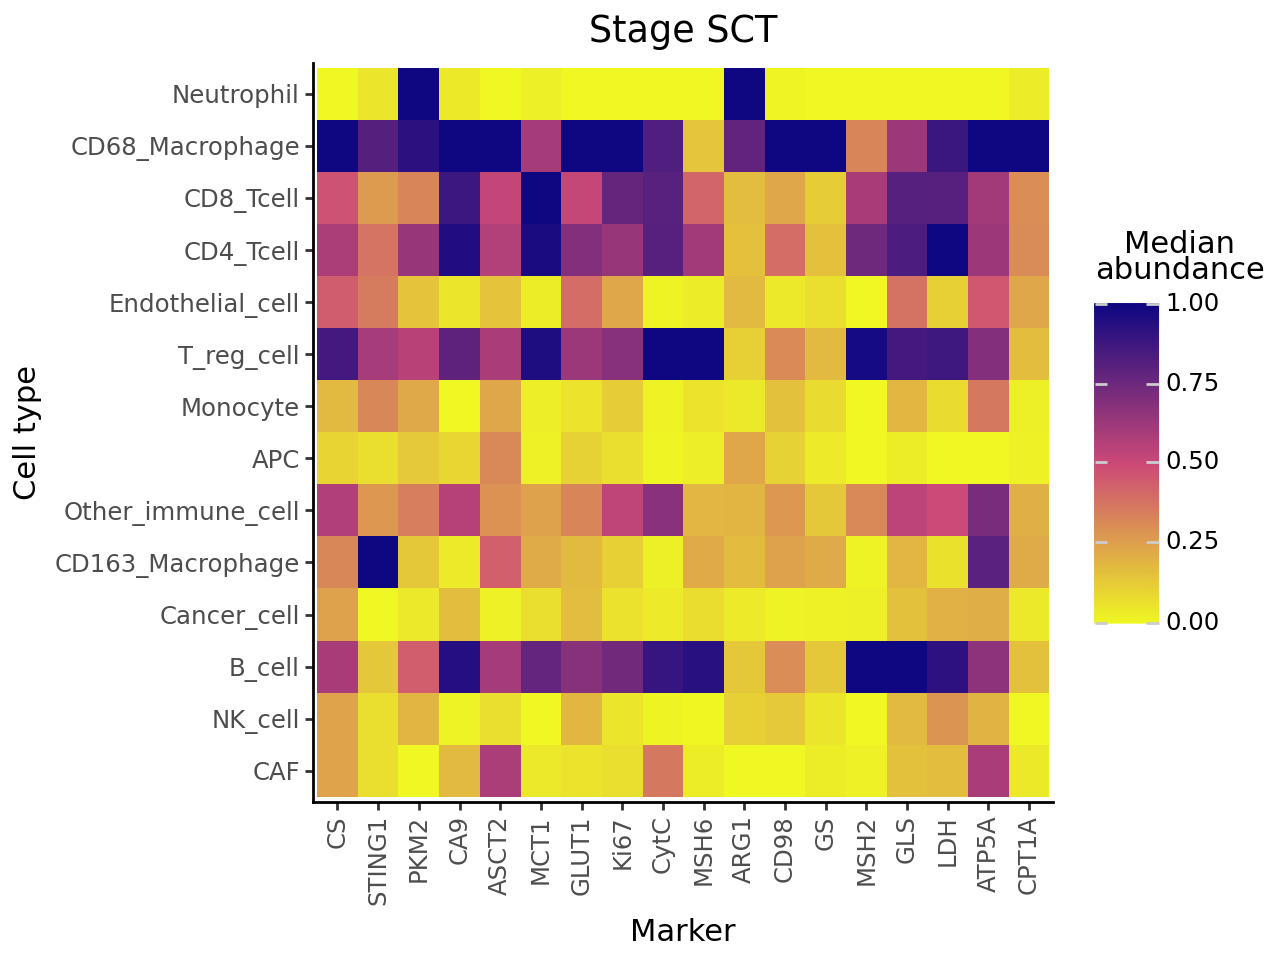

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3.2 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/heatmap_all_markers_scaled_stage_SCT.png


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3.2 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/heatmap_all_markers_scaled_stage_SCT.pdf
/tmp/ipykernel_359020/258105503.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_359020/258105503.py:36: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


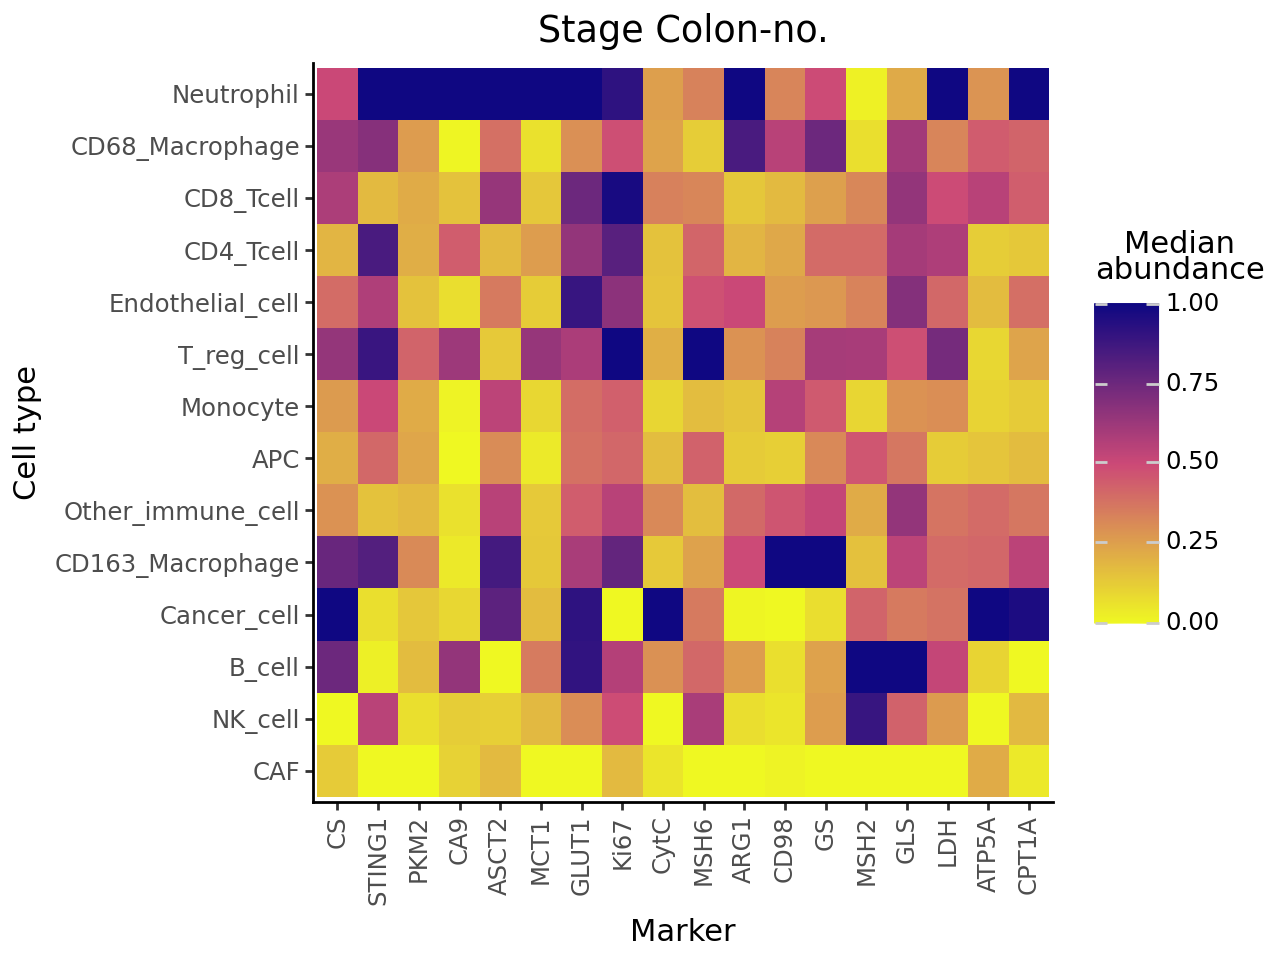

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3.2 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/heatmap_all_markers_scaled_stage_Colon-no..png


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 3.2 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/heatmap_all_markers_scaled_stage_Colon-no..pdf


In [10]:
for stage in adata.obs['Stage'].unique():
    if pd.isna(stage):
        continue

    df = adata.obs.loc[adata.obs['Stage'] == stage, all_functional_and_metab]
    df["cell_type"] = adata.obs.loc[adata.obs['Stage'] == stage, "annotation_consensus"].values
    df = df.groupby("cell_type").median().T
    df = df.drop("Unclear", axis=1)

    # We keep the order of the markers and cell types from the previous analysis for consistency

    # Scale df values so that each row (abundance for a given marker) is between 0 and 1
    df = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis = 1)

    # Reorder the DataFrame
    df_reordered = df.iloc[row_order, :].iloc[:, col_order]

    # Melt the DataFrame for plotnine
    df_melted = df_reordered.melt(ignore_index=False).reset_index()

    # Update the levels of the categorical variables to reflect the new order
    df_melted["index"] = pd.Categorical(df_melted["index"], categories=df_reordered.index, ordered=True)
    df_melted["cell_type"] = pd.Categorical(df_melted["cell_type"], categories=df_reordered.columns.to_list(), ordered=True)

    # Display as heatmap
    gp = (
        ggplot(df_melted, aes(x="index", y="cell_type")) 
        + geom_tile(aes(fill="value")) 
        + theme_classic() 
        + theme(axis_text_x=element_text(angle=90)) 
        + labs(y="Cell type", x="Marker", fill="Median\nabundance") 
        # Use reverted plasma color palette
        + scale_fill_gradientn(colors = ["#EFF822", "#CC4977","#0F0782"])
        + ggtitle(f"Stage {stage}")
    )
    print(gp)
    ggsave(gp, f"../../figures/fig3/heatmap_all_markers_scaled_stage_{stage}.png", width = 6, height = 3.2)
    ggsave(gp, f"../../figures/fig3/heatmap_all_markers_scaled_stage_{stage}.pdf", width = 6, height = 3.2)

GLUT1 high in neutrophils and cancer cells – not in healthy epithelial cells. Also higher proliferation (Ki67). Also CD98 (neutral aa transporter) high, MSH6 / MSH2 / LDH low in cancer vs epithelial.  
Caveat: scaled scores are computed per marker per stage and not across stages. Scaling values before computing the median means giving weight to outliers (if using min and max) or doing what's done already (if using small/large percentiles).

## Cancer cell metab subgroups
Leiden on metabolic markers only? Enrichment by pathway then cluster?

### Score 0: metabolic marker intensities

In [11]:
# A few FOVs show only few epithelial cells and might only add noise to the analysis
meta = adata.obs.loc[(adata.obs.consensus == "Cancer_cell"), ["Stage","fov"]] 
sparse_epi_fovs = meta.fov.value_counts()[meta.fov.value_counts() <= 20].index

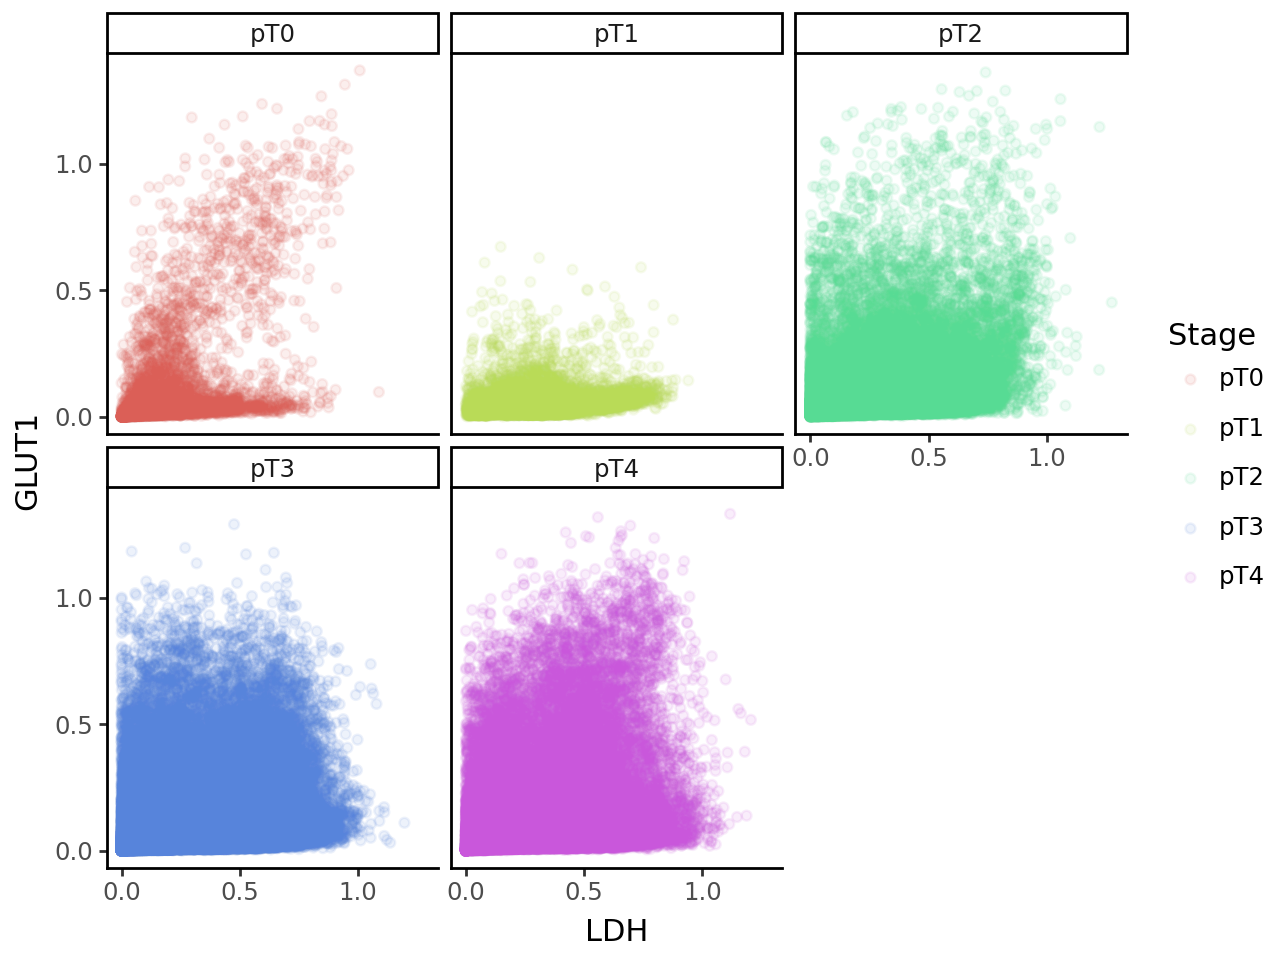

In [12]:
df = adata.obs.loc[(adata.obs.consensus == "Cancer_cell") & (~adata.obs.fov.isin(sparse_epi_fovs)),
              ["LDH", "GLUT1",'pT group']] 
df["Stage"] = df["pT group"].replace({pd.NA: "pT0"})
gp = (ggplot(df, aes(x="LDH", y="GLUT1", color='Stage')) 
      + geom_point(alpha = 0.1) + theme_classic() + facet_wrap("~Stage")
)
gp

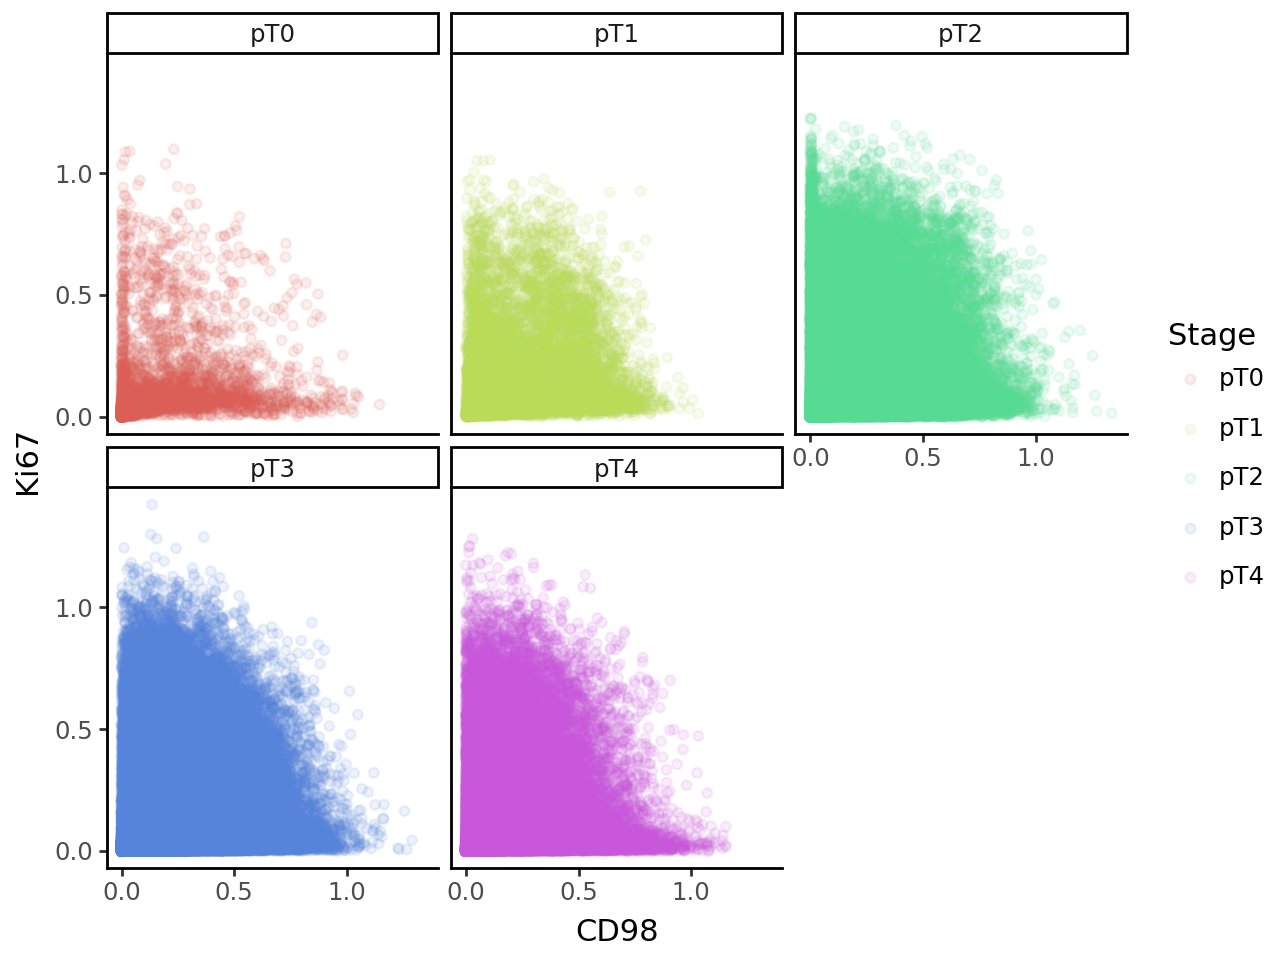

In [13]:
df = adata.obs.loc[(adata.obs.consensus == "Cancer_cell") & (~adata.obs.fov.isin(sparse_epi_fovs)),
              ["CD98", "Ki67",'pT group']] 
df["Stage"] = df["pT group"].replace({pd.NA: "pT0"})
gp = (ggplot(df, aes(x="CD98", y="Ki67", color='Stage')) 
      + geom_point(alpha = 0.1) + theme_classic() + facet_wrap("~Stage")
)
gp

In [14]:
df = adata.obs.loc[adata.obs.fov == "A1c",adata.obs.columns[:23]]
df["cell_type"] = adata.obs.loc[adata.obs.fov == "A1c", "annotation_consensus"].values
df = df.groupby("cell_type").median().T
df = df.drop("Unclear", axis=1)

df

/tmp/ipykernel_359020/1429918715.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


cell_type  APC  B_cell       CAF  CD4_Tcell  CD8_Tcell  CD68_Macrophage  \
CA9        NaN     NaN  0.055538   0.078143   0.048818         0.035258   
nuclei     NaN     NaN  0.055388   0.102344   0.072142         0.071697   
CD98       NaN     NaN  0.043669   0.122135   0.026525         0.098489   
CytC       NaN     NaN  0.008439   0.004835   0.003600         0.004412   
MSH2       NaN     NaN  0.054501   0.081308   0.037512         0.031720   
MCT1       NaN     NaN  0.010393   0.027632   0.005337         0.025734   
PDL1       NaN     NaN  0.039246   0.076080   0.026495         0.086246   
PD1        NaN     NaN  0.021259   0.111429   0.241379         0.043126   
ASCT2      NaN     NaN  0.043476   0.020827   0.013211         0.018624   
LDH        NaN     NaN  0.108664   0.144425   0.121743         0.162368   
STING1     NaN     NaN  0.114268   0.382532   0.064461         0.141303   
DCN        NaN     NaN  0.007430   0.027253   0.023454         0.016346   
GS         NaN     NaN  0.054616   0.099771   0.059592         0.197789   
GLS        NaN     NaN  0.050395   0.048674   0.034996         0.030546   
ATP5A      NaN     NaN  0.043939   0.026182   0.029523         0.032182   
CS         NaN     NaN  0.152592   0.165677   0.098170         0.123291   
PKM2       NaN     NaN  0.294911   0.509276   0.397060         0.560980   
GLUT1      NaN     NaN  0.014018   0.017839   0.022501         0.026342   
MSH6       NaN     NaN  0.020039   0.029928   0.019225         0.023538   
ARG1       NaN     NaN  0.043154   0.110916   0.063599         0.170584   
CPT1A      NaN     NaN  0.152635   0.154652   0.121552         0.189774   
Vimentin   NaN     NaN  0.125785   0.202545   0.172126         0.462761   
Ki67       NaN     NaN  0.019736   0.038000   0.033737         0.060056   

cell_type  CD163_Macrophage  Cancer_cell  Endothelial_cell  Monocyte  \
CA9                0.046149     0.102050          0.045288  0.042925   
nuclei             0.096343     0.120935          0.067599  0.084304   
CD98               0.093303     0.075665          0.030191  0.096706   
CytC               0.006043     0.014408          0.016248  0.004816   
MSH2               0.078784     0.393670          0.093896  0.069185   
MCT1               0.011732     0.019525          0.008524  0.021816   
PDL1               0.076150     0.033919          0.033932  0.070532   
PD1                0.041665     0.030438          0.049629  0.050837   
ASCT2              0.021246     0.121512          0.029981  0.021462   
LDH                0.130142     0.320069          0.108908  0.147368   
STING1             0.199934     0.094590          0.368925  0.149677   
DCN                0.013267     0.011332          0.021728  0.017422   
GS                 0.242254     0.048014          0.040325  0.123697   
GLS                0.035830     0.141766          0.098361  0.039630   
ATP5A              0.026201     0.066487          0.050969  0.033623   
CS                 0.174519     0.187873          0.172746  0.136306   
PKM2               0.443988     0.209884          0.199951  0.499672   
GLUT1              0.019525     0.035092          0.020711  0.024488   
MSH6               0.043487     0.167183          0.064988  0.047512   
ARG1               0.079670     0.067021          0.128666  0.077140   
CPT1A              0.153891     0.420906          0.202756  0.148481   
Vimentin           0.222198     0.002530          0.288406  0.301048   
Ki67               0.024120     0.105639          0.033156  0.039542   

cell_type   NK_cell  Neutrophil  Other_immune_cell  T_reg_cell  
CA9        0.061607    0.256805           0.040949         NaN  
nuclei     0.112168    0.041750           0.052645         NaN  
CD98       0.093615    0.025070           0.042080         NaN  
CytC       0.012873    0.006051           0.005882         NaN  
MSH2       0.114144    0.041219           0.056630         NaN  
MCT1       0.020199    0.218459           0.012438         NaN  
PDL1       0.07

In [15]:
df = adata.obs.loc[adata.obs.fov == "E4a",adata.obs.columns[:23]]
df["cell_type"] = adata.obs.loc[adata.obs.fov == "E4a", "annotation_consensus"].values
df = df.groupby("cell_type").median().T
df = df.drop("Unclear", axis=1)

df

/tmp/ipykernel_359020/2782361450.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


cell_type       APC    B_cell       CAF  CD4_Tcell  CD8_Tcell  \
CA9        0.035004  0.057603  0.021852   0.041191   0.038137   
nuclei     0.152907  0.197528  0.021665   0.160873   0.133820   
CD98       0.083578  0.076111  0.025040   0.105763   0.070404   
CytC       0.029225  0.051617  0.007527   0.025359   0.063498   
MSH2       0.068123  0.061315  0.001962   0.068387   0.027101   
MCT1       0.014163  0.030933  0.004374   0.021794   0.021791   
PDL1       0.030532  0.025223  0.027468   0.032210   0.032772   
PD1        0.024522  0.068456  0.007798   0.057274   0.038982   
ASCT2      0.086162  0.035979  0.091540   0.062789   0.136139   
LDH        0.089201  0.171648  0.040294   0.142871   0.096324   
STING1     0.286856  0.255821  0.104504   0.489734   0.220452   
DCN        0.091940  0.013308  0.158095   0.034538   0.030067   
GS         0.098924  0.114957  0.038110   0.115642   0.098283   
GLS        0.200783  0.308985  0.050108   0.225730   0.204212   
ATP5A      0.207585  0.168006  0.084759   0.165364   0.269889   
CS         0.310425  0.377011  0.180665   0.300163   0.265054   
PKM2       0.088583  0.125080  0.032940   0.094542   0.064988   
GLUT1      0.013510  0.024508  0.008509   0.019429   0.020658   
MSH6       0.045722  0.029466  0.008853   0.048987   0.035909   
ARG1       0.101242  0.108427  0.051923   0.101863   0.102022   
CPT1A      0.110532  0.133571  0.063836   0.118082   0.177073   
Vimentin   0.429895  0.485389  0.237669   0.490980   0.349298   
Ki67       0.057658  0.066849  0.020974   0.089312   0.091752   

cell_type  CD68_Macrophage  CD163_Macrophage  Cancer_cell  Endothelial_cell  \
CA9               0.035852          0.019917     0.041393          0.029106   
nuclei            0.068751          0.074550     0.119995          0.103231   
CD98              0.201234          0.200189     0.015133          0.089821   
CytC              0.018639          0.022319     0.118467          0.017256   
MSH2              0.014071          0.023952     0.080359          0.043006   
MCT1              0.016594          0.014709     0.024444          0.019817   
PDL1              0.074456          0.062447     0.043463          0.033527   
PD1               0.023787          0.019457     0.026862          0.025467   
ASCT2             0.095745          0.082638     0.187197          0.064751   
LDH               0.056487          0.059172     0.122512          0.096797   
STING1            0.415862          0.500581     0.258225          0.321966   
DCN               0.110108          0.135388     0.005813          0.082625   
GS                0.236767          0.160150     0.047868          0.090872   
GLS               0.167694          0.160975     0.126021          0.141482   
ATP5A             0.196825          0.218728     0.348029          0.148042   
CS                0.265961          0.260062     0.333942          0.223644   
PKM2              0.065319          0.051049     0.072727          0.046675   
GLUT1             0.012391          0.013178     0.020144          0.023368   
MSH6              0.022260          0.041453     0.059675          0.058567   
ARG1              0.326588          0.173994     0.050015          0.177412   
CPT1A             0.161206          0.134233     0.283550          0.107445   
Vimentin          0.449664          0.361569     0.005923          0.452570   
Ki67              0.053842          0.043335     0.023537          0.050474   

cell_type  Monocyte   NK_cell  Neutrophil  Other_immune_cell  T_reg_cell  
CA9        0.032171  0.029487         NaN           0.037074    0.051236  
nuclei     0.070444  0.141994         NaN           0.118373    0.193613  
CD98       0.127383  0.052486         NaN           0.146768    0.230052  
CytC       0.012576  0.017081         NaN           0.025723    0.022147  
MSH2       0.027724  0.133433         NaN           0.042162    0.130433  
MCT1       0.013961  0.022495         NaN           0.021761    0.042531  
PDL1       0.0357

In [16]:
df = pd.DataFrame(adata.X[adata.obs.fov == "E4a",:], columns=adata.var_names)
df["cell_type"] = adata.obs.loc[adata.obs.fov == "E4a", "annotation_consensus"].values
df = df.groupby("cell_type").median().T
df = df.drop("Unclear", axis=1)

df

/tmp/ipykernel_359020/3666292284.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


cell_type       APC    B_cell       CAF  CD4_Tcell  CD8_Tcell  \
SMA        0.000002  0.000000  0.426162   0.000000   0.000007   
CD4        0.252512  0.283803  0.020551   0.513011   0.074547   
CD31       0.060470  0.065456  0.013654   0.065802   0.064817   
CD7        0.019108  0.108589  0.006571   0.212815   0.261497   
CD163      0.005390  0.002129  0.002374   0.007634   0.003864   
CD68       0.060792  0.028396  0.006166   0.031516   0.010363   
CD8        0.001408  0.001117  0.000107   0.001038   0.542065   
CD3e       0.043631  0.202377  0.008848   0.501362   0.426605   
MPO        0.000977  0.001076  0.000367   0.000897   0.001159   
CD20       0.016786  0.623778  0.000333   0.017862   0.003256   
HLADRa     0.383456  0.112833  0.022708   0.099509   0.037014   
CD14       0.125482  0.085855  0.082932   0.127803   0.095027   
CD45       0.351530  0.658863  0.051301   0.547355   0.429805   
PanCK      0.060473  0.109605  0.036197   0.081243   0.123399   
FoxP3      0.016921  0.028448  0.005769   0.022478   0.020198   

cell_type  CD68_Macrophage  CD163_Macrophage  Cancer_cell  Endothelial_cell  \
SMA               0.000055          0.017836     0.000000          0.006157   
CD4               0.236547          0.238414     0.025692          0.056589   
CD31              0.113695          0.104301     0.021593          0.302821   
CD7               0.019894          0.019380     0.008120          0.012574   
CD163             0.154292          0.341741     0.002536          0.008481   
CD68              0.451159          0.242252     0.004772          0.056896   
CD8               0.000461          0.000000     0.002316          0.000257   
CD3e              0.025664          0.025551     0.015844          0.016727   
MPO               0.000733          0.000815     0.001354          0.001031   
CD20              0.007902          0.004748     0.003385          0.014820   
HLADRa            0.156735          0.064119     0.028505          0.030538   
CD14              0.340966          0.433157     0.030687          0.103278   
CD45              0.252145          0.224800     0.013108          0.117703   
PanCK             0.059646          0.055931     0.292259          0.060867   
FoxP3             0.018955          0.017908     0.030485          0.022947   

cell_type  Monocyte   NK_cell  Neutrophil  Other_immune_cell  T_reg_cell  
SMA        0.000048  0.002288         NaN           0.000000    0.000052  
CD4        0.091187  0.093623         NaN           0.164609    0.489850  
CD31       0.078419  0.062049         NaN           0.063946    0.083960  
CD7        0.012727  0.201558         NaN           0.018273    0.438318  
CD163      0.021958  0.007173         NaN           0.022094    0.006865  
CD68       0.053707  0.016748         NaN           0.220729    0.140238  
CD8        0.000253  0.002048         NaN           0.000969    0.009164  
CD3e       0.019043  0.060518         NaN           0.034056    0.675130  
MPO        0.000743  0.000992         NaN           0.001175    0.002371  
CD20       0.002516  0.009520         NaN           0.007265    0.215162  
HLADRa     0.037014  0.061380         NaN           0.087016    0.042090  
CD14       0.207969  0.160942         NaN           0.146106    0.096510  
CD45       0.216365  0.308824         NaN           0.263886    0.569619  
PanCK      0.050275  0.070197         NaN           0.060298    0.117067  
FoxP3      0.016977  0.062144         NaN           0.023408    0.607813

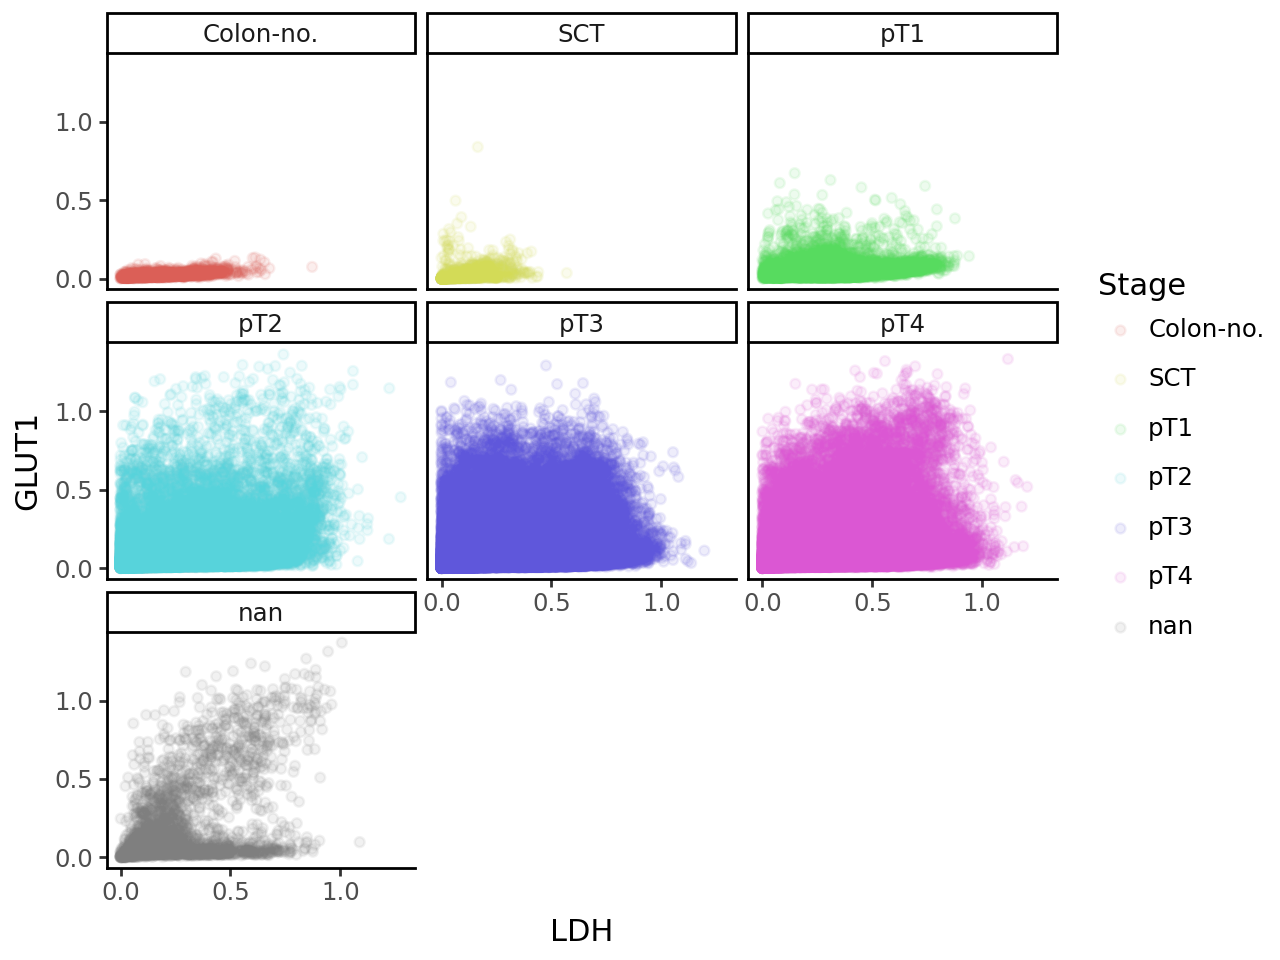

In [17]:
df = adata.obs.loc[adata.obs.consensus == "Cancer_cell",["LDH", "GLUT1",'pT group','fov']] 
df["Stage"] = df["pT group"]
# # E1 and E2 samples are annotated 'SCT' while E3 and E4 are 'Colon-no.'
df.loc[df.fov.str.contains("E4"), "Stage"] = "Colon-no."
df.loc[df.fov.str.contains("E3"), "Stage"] = "Colon-no."
df.loc[df.fov.str.contains("E2"), "Stage"] = "SCT"
df.loc[df.fov.str.contains("E1"), "Stage"] = "SCT"

gp = (ggplot(df, aes(x="LDH", y="GLUT1", color='Stage')) 
      + geom_point(alpha = 0.1) + theme_classic() + facet_wrap("~Stage")
)
gp

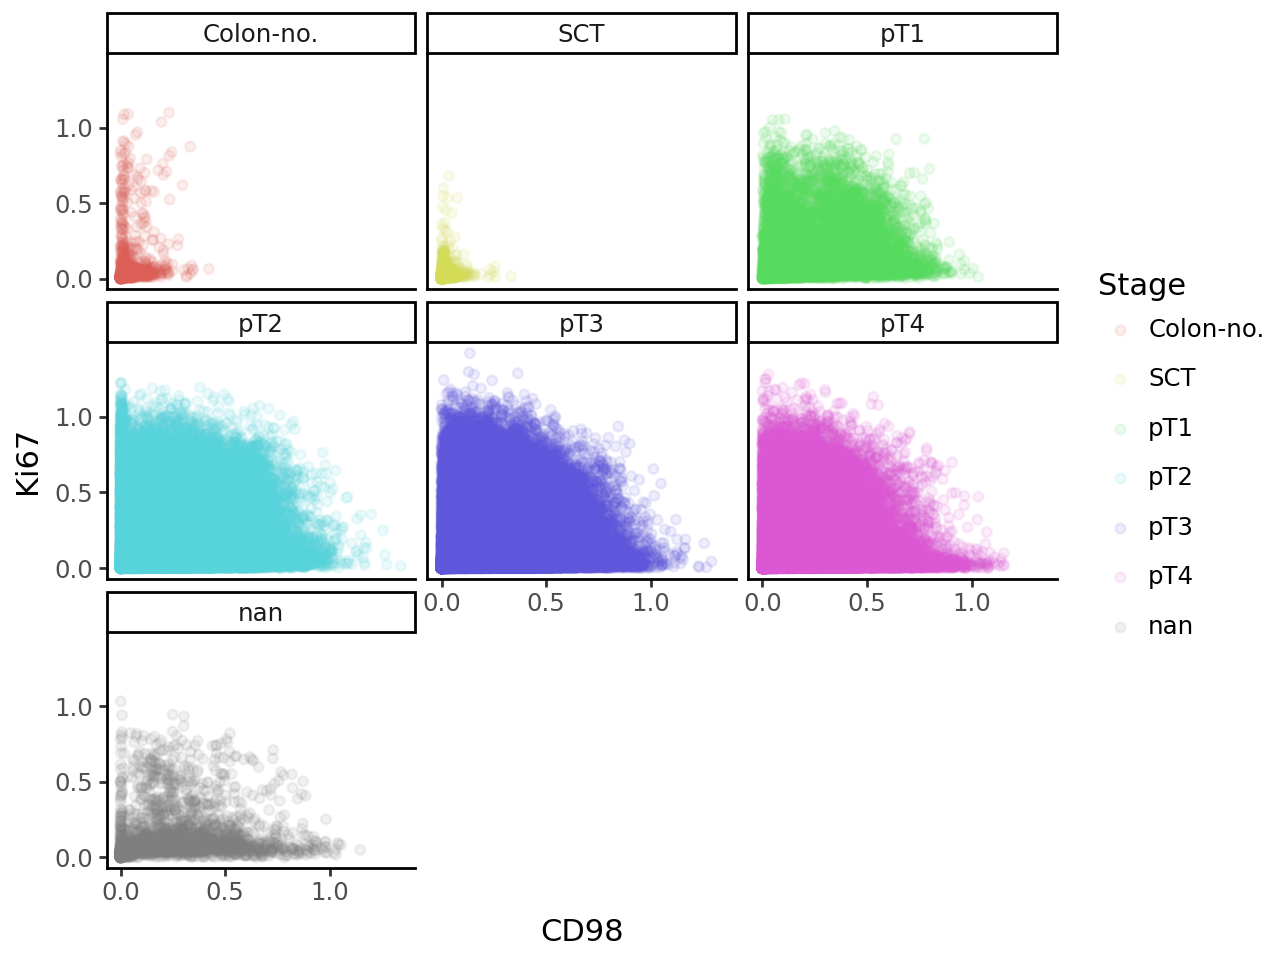

In [18]:
df = adata.obs.loc[adata.obs.consensus == "Cancer_cell",["CD98", "Ki67",'pT group','fov']] 
df["Stage"] = df["pT group"]
# # E1 and E2 samples are annotated 'SCT' while E3 and E4 are 'Colon-no.'
df.loc[df.fov.str.contains("E4"), "Stage"] = "Colon-no."
df.loc[df.fov.str.contains("E3"), "Stage"] = "Colon-no."
df.loc[df.fov.str.contains("E2"), "Stage"] = "SCT"
df.loc[df.fov.str.contains("E1"), "Stage"] = "SCT"

gp = (ggplot(df, aes(x="CD98", y="Ki67", color='Stage')) 
      + geom_point(alpha = 0.1) + theme_classic() + facet_wrap("~Stage")
)
gp

/tmp/ipykernel_359020/1773027446.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_359020/1773027446.py:37: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


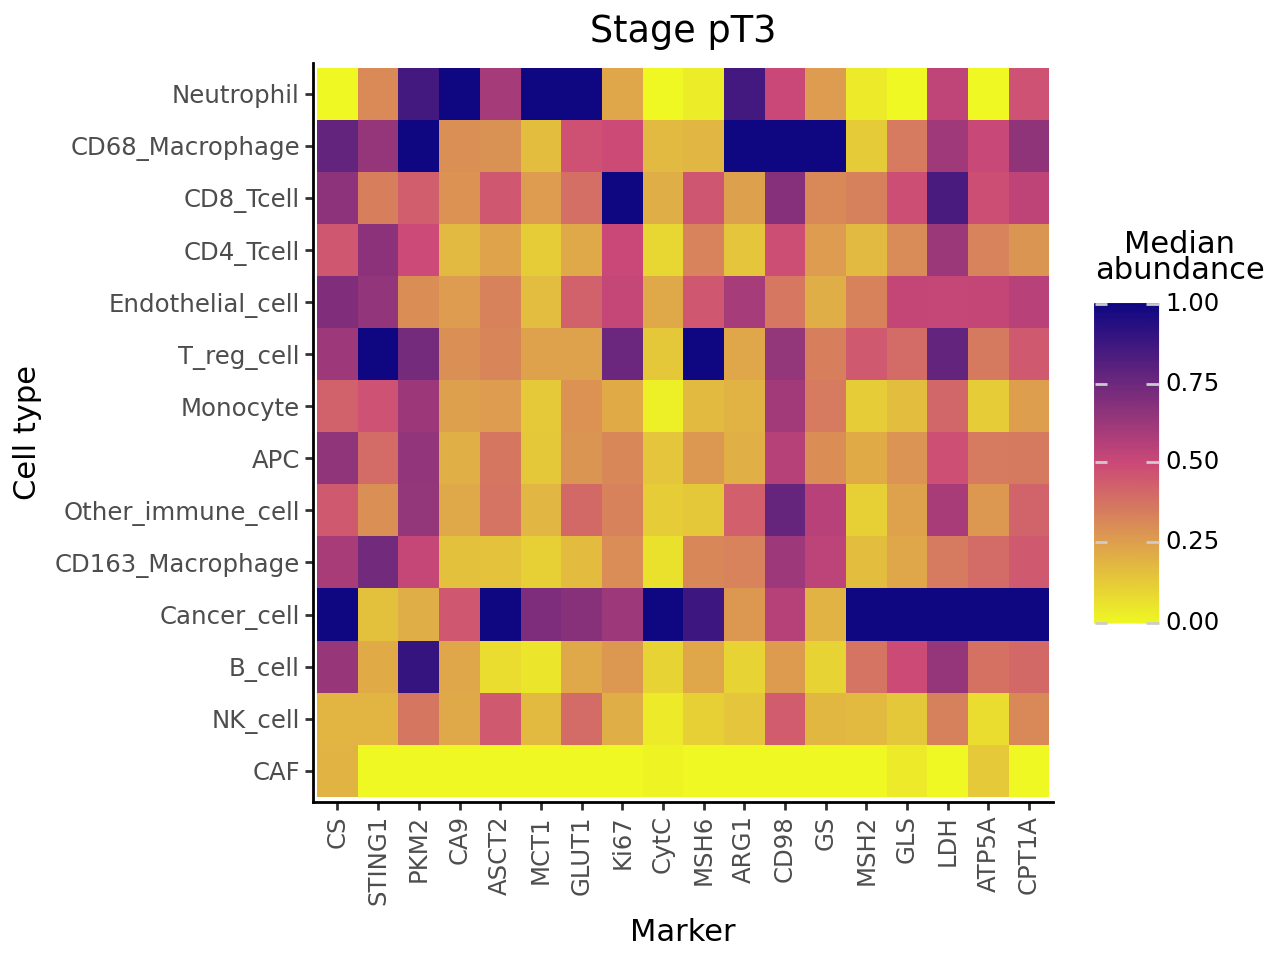

/tmp/ipykernel_359020/1773027446.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_359020/1773027446.py:37: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


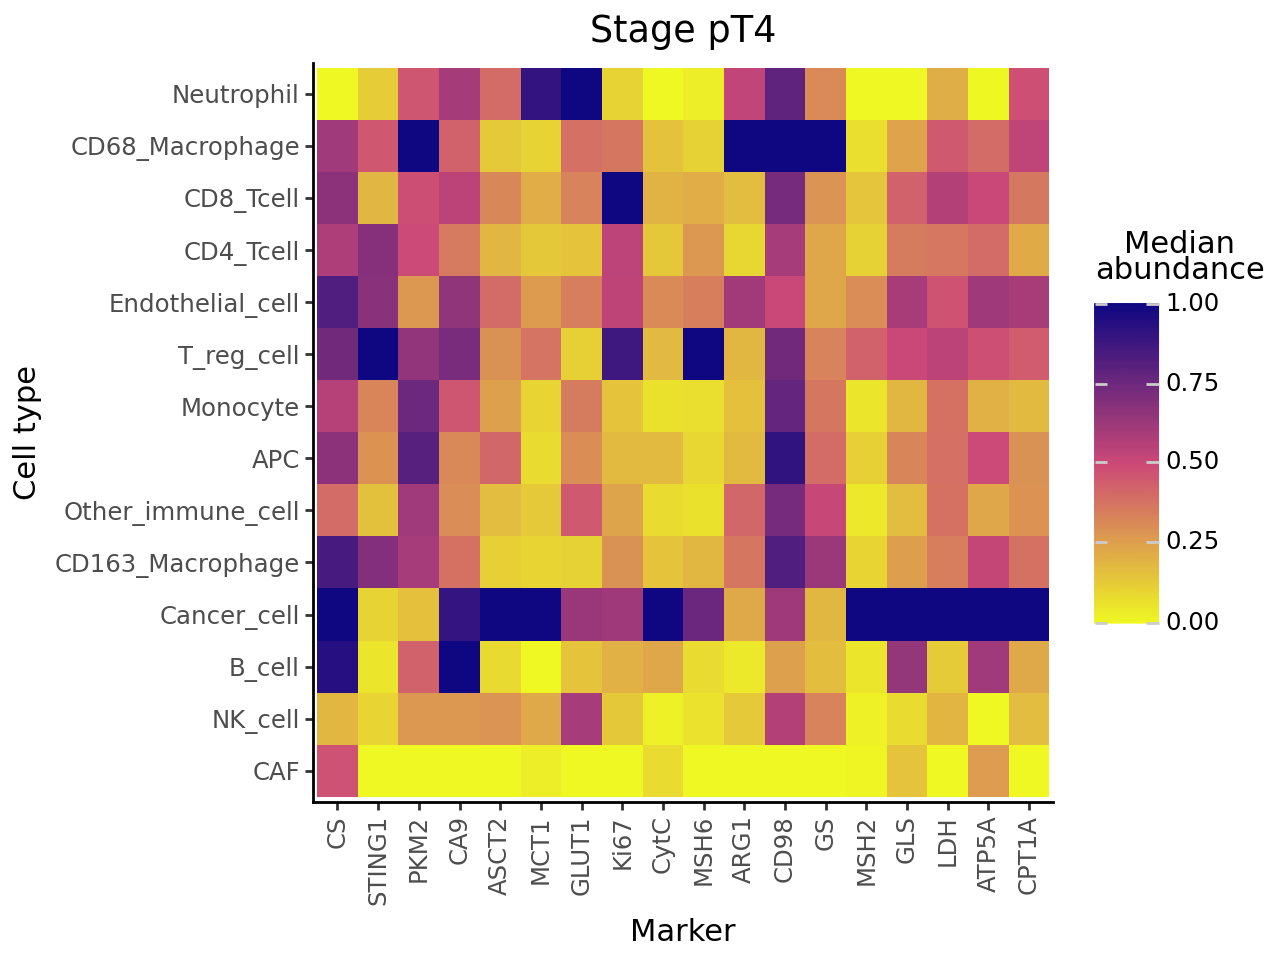

/tmp/ipykernel_359020/1773027446.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_359020/1773027446.py:37: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


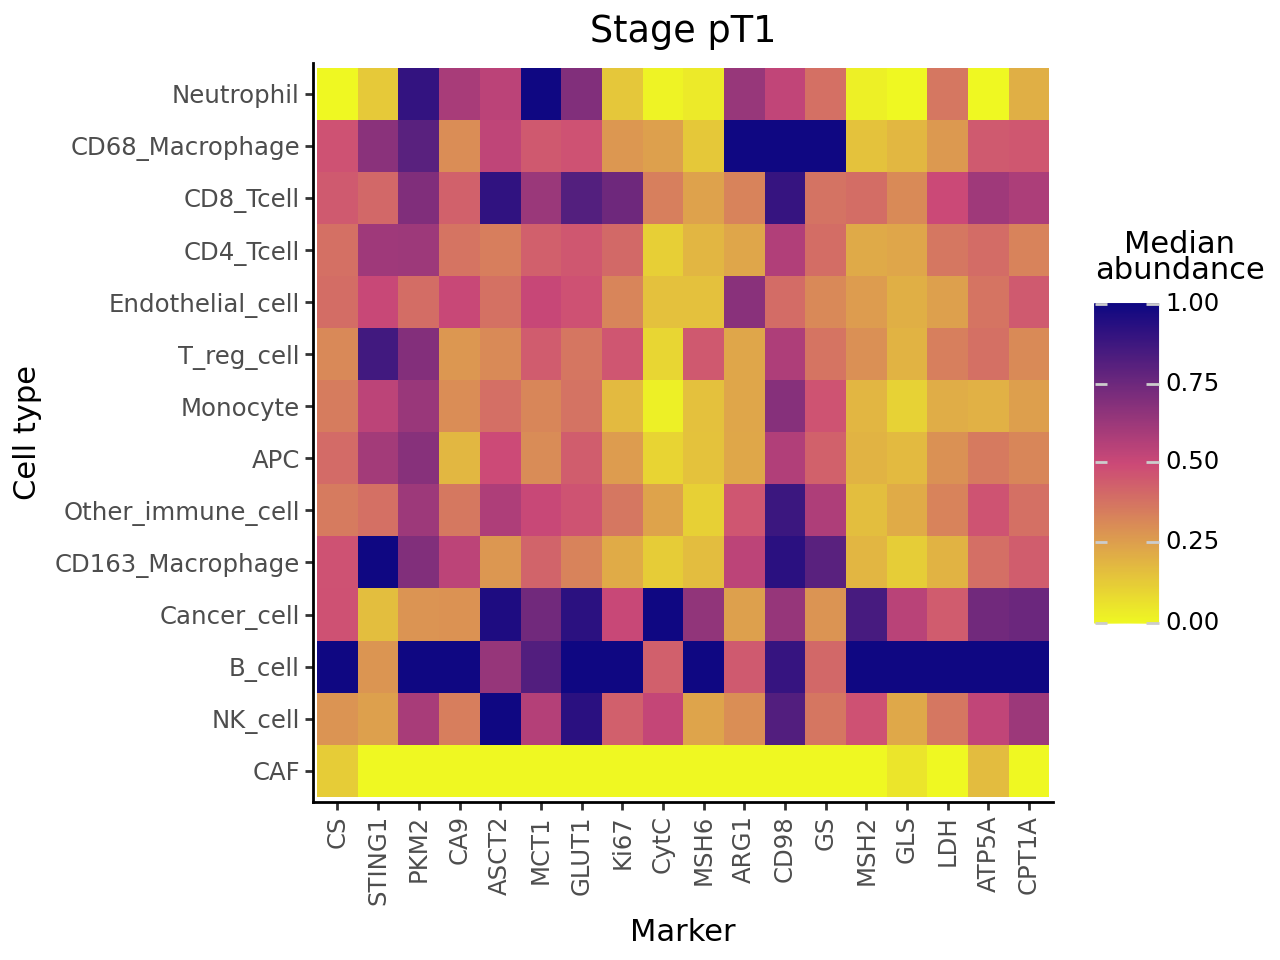

/tmp/ipykernel_359020/1773027446.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_359020/1773027446.py:37: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


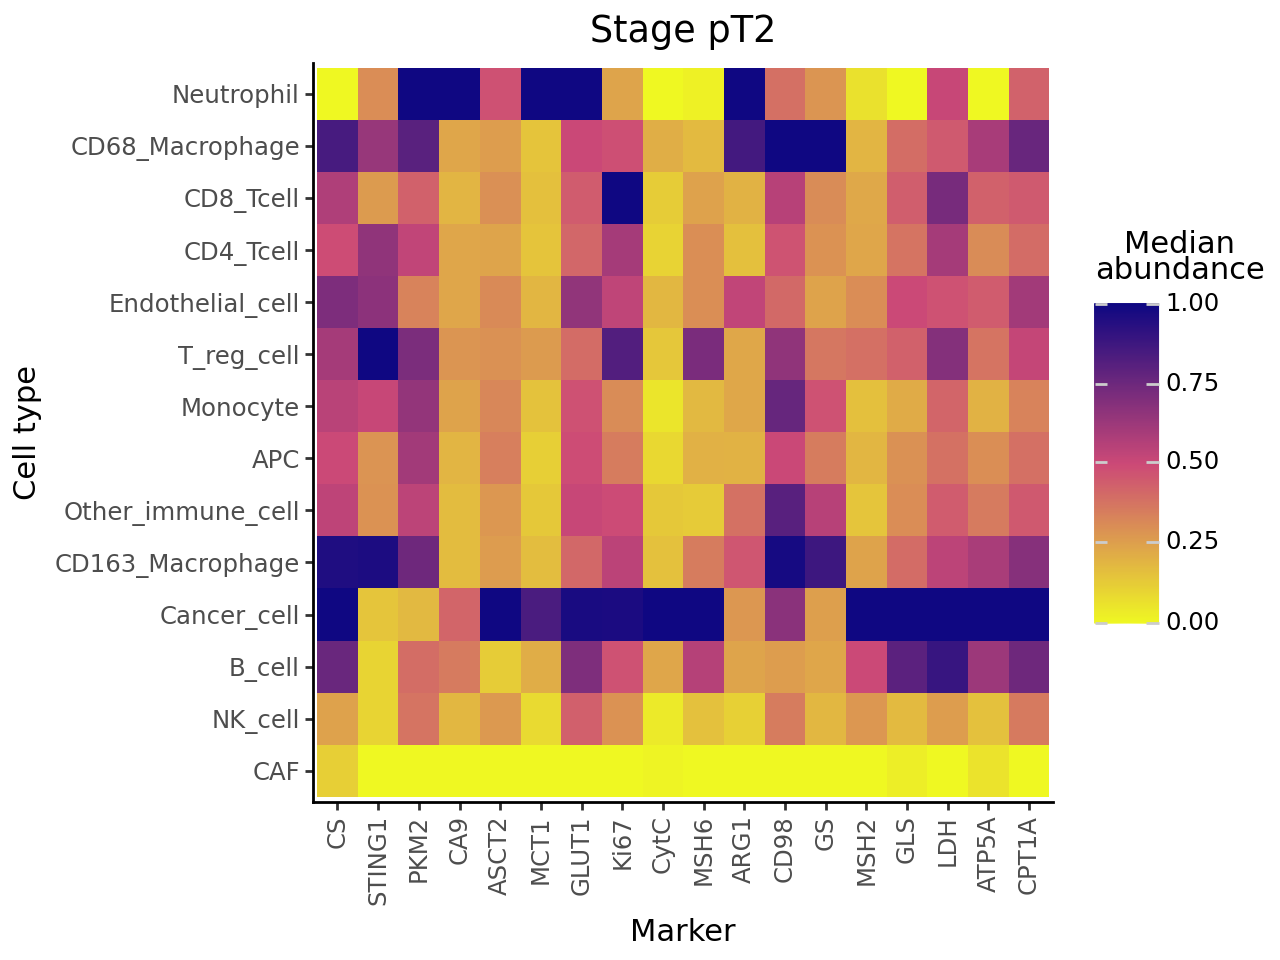

/tmp/ipykernel_359020/1773027446.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/tmp/ipykernel_359020/1773027446.py:37: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


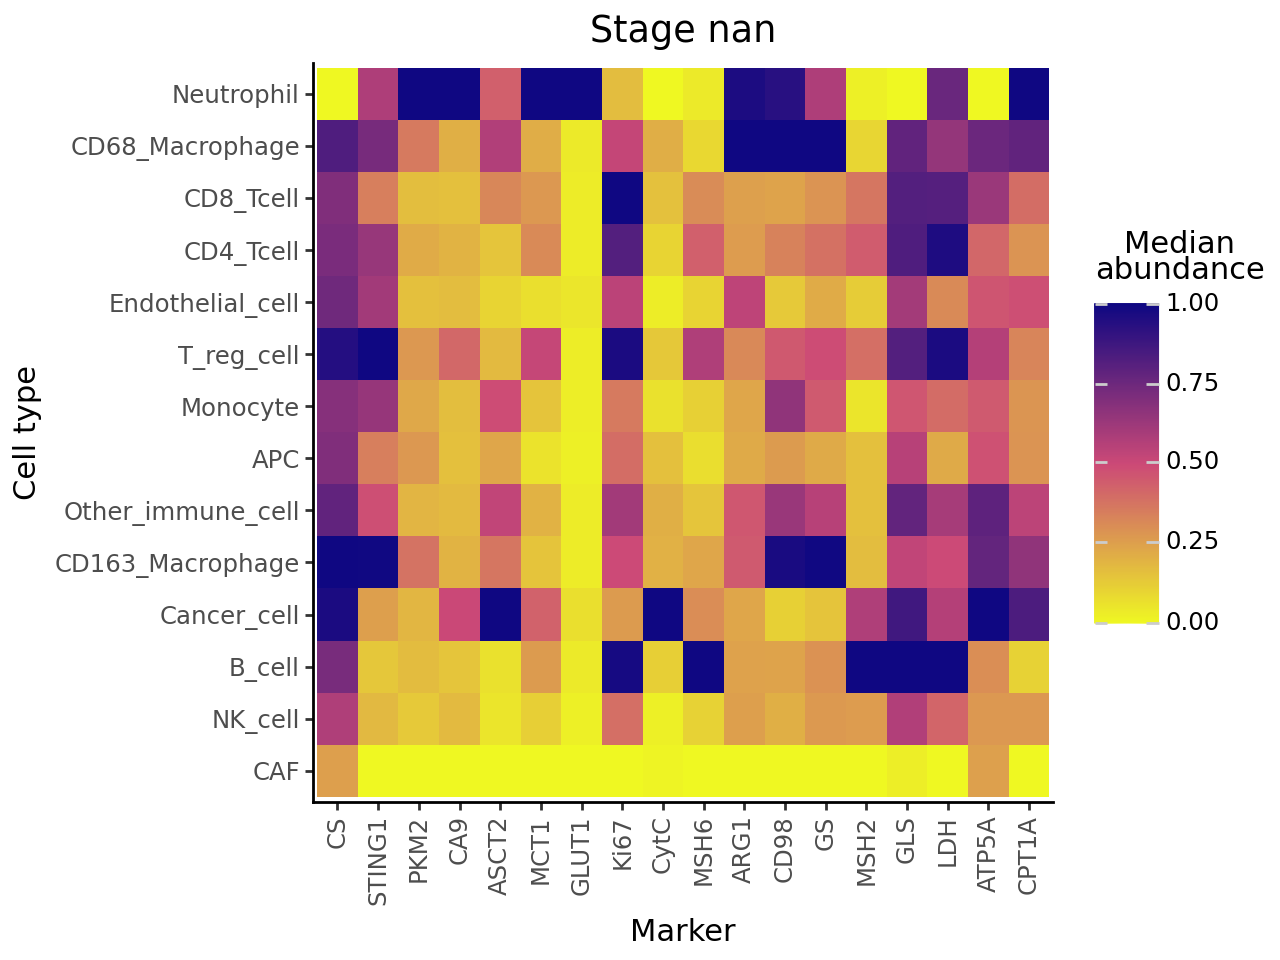

In [19]:
for stage in adata.obs['pT group'].unique():
    if pd.isna(stage):
        df = adata.obs.loc[adata.obs['pT group'].isna(), all_functional_and_metab]
        df["cell_type"] = adata.obs.loc[adata.obs['pT group'].isna(), "annotation_consensus"].values
    else:
        df = adata.obs.loc[adata.obs['pT group'] == stage, all_functional_and_metab]
        df["cell_type"] = adata.obs.loc[adata.obs['pT group'] == stage, "annotation_consensus"].values
    df = df.groupby("cell_type").median().T
    df = df.drop("Unclear", axis=1)

    # We keep the order of the markers and cell types from the previous analysis for consistency

    # Scale df values so that each row (abundance for a given marker) is between 0 and 1
    df = df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis = 1)

    # Reorder the DataFrame
    df_reordered = df.iloc[row_order, :].iloc[:, col_order]

    # Melt the DataFrame for plotnine
    df_melted = df_reordered.melt(ignore_index=False).reset_index()

    # Update the levels of the categorical variables to reflect the new order
    df_melted["index"] = pd.Categorical(df_melted["index"], categories=df_reordered.index, ordered=True)
    df_melted["cell_type"] = pd.Categorical(df_melted["cell_type"], categories=df_reordered.columns.to_list(), ordered=True)

    # Display as heatmap
    gp = (
        ggplot(df_melted, aes(x="index", y="cell_type")) 
        + geom_tile(aes(fill="value")) 
        + theme_classic() 
        + theme(axis_text_x=element_text(angle=90)) 
        + labs(y="Cell type", x="Marker", fill="Median\nabundance") 
        # Use reverted plasma color palette
        + scale_fill_gradientn(colors = ["#EFF822", "#CC4977","#0F0782"])
        + ggtitle(f"Stage {stage}")
    )
    print(gp)
    # ggsave(gp, f"figures/fig3/heatmap_all_markers_scaled_stage_{stage}.png", width = 6, height = 3.2)

## Cancer cell metabolism
In this section, we explore the variations in metabolic activitiy of epithelial / malignant cells, and how it evolves with the disease stage.  
For now, we ignore the influence of other cell types, and start by looking at metabolic markers in cancer cells only.    
While a classification at the cell level shows the informativeness of individual cell metabolic profiles, not all cells have to be representative of the disease as a whole. The most relevant representation should thus be the one best representing FOVs/samples. For given markers, the aggregation can be attempted as follows: no aggregation, mean profile (train on cells or on mean profiles), median profile (train on cells on or median profiles), clustering and proportions. We want to compare these methods (and ideally later use the same split for multicellular / spatial analyses) -> 4xCV + validation set (per FOV) = 1 healthy donor per fold.  
How does it relate to proliferation/aggressiveness?  
QC: cosine similarity between cells from the same stage?  

### Visualization only

In [20]:
adata.obs.consensus.value_counts()

consensus
Cancer_cell          262411
Unclear               90917
CAF                   75961
Monocyte              29922
Endothelial_cell      29646
Neutrophil            19169
CD4_Tcell             15340
Other_immune_cell     14025
CD68_Macrophage       10775
CD163_Macrophage      10747
CD8_Tcell              6824
NK_cell                3973
APC                    3691
B_cell                 3684
T_reg_cell             1926
Name: count, dtype: int64

In [21]:
metab_markers = ['CA9', 'CD98', 'CytC', 'MCT1', 'ASCT2', 'LDH', 'GS', 'GLS', 'ATP5A', 'CS', 'PKM2', 'GLUT1', 'ARG1', 'CPT1A', 'Ki67']

metab_and_functional = metab_markers + ["STING1", "MSH2", "MSH6", "PDL1"]


# Only metabolic markers for cancer/epithelial cells
# df = adata.obs.loc[adata.obs.consensus == "Cancer_cell",metab_markers] 
df = adata.obs.loc[(adata.obs.consensus == "Cancer_cell") & (~adata.obs.fov.isin(sparse_epi_fovs)),
                   metab_and_functional] 
# meta = adata.obs.loc[adata.obs.consensus == "Cancer_cell",["Stage","fov"]]
meta = adata.obs.loc[(adata.obs.consensus == "Cancer_cell") & (~adata.obs.fov.isin(sparse_epi_fovs)),
                   ["Stage","fov"]] 

# Only keep well-annotated stages
epithelial_subset = meta["Stage"].isin(["Colon-no.", "pT1", "pT2", "pT3", "pT4"]).values

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_CA9_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


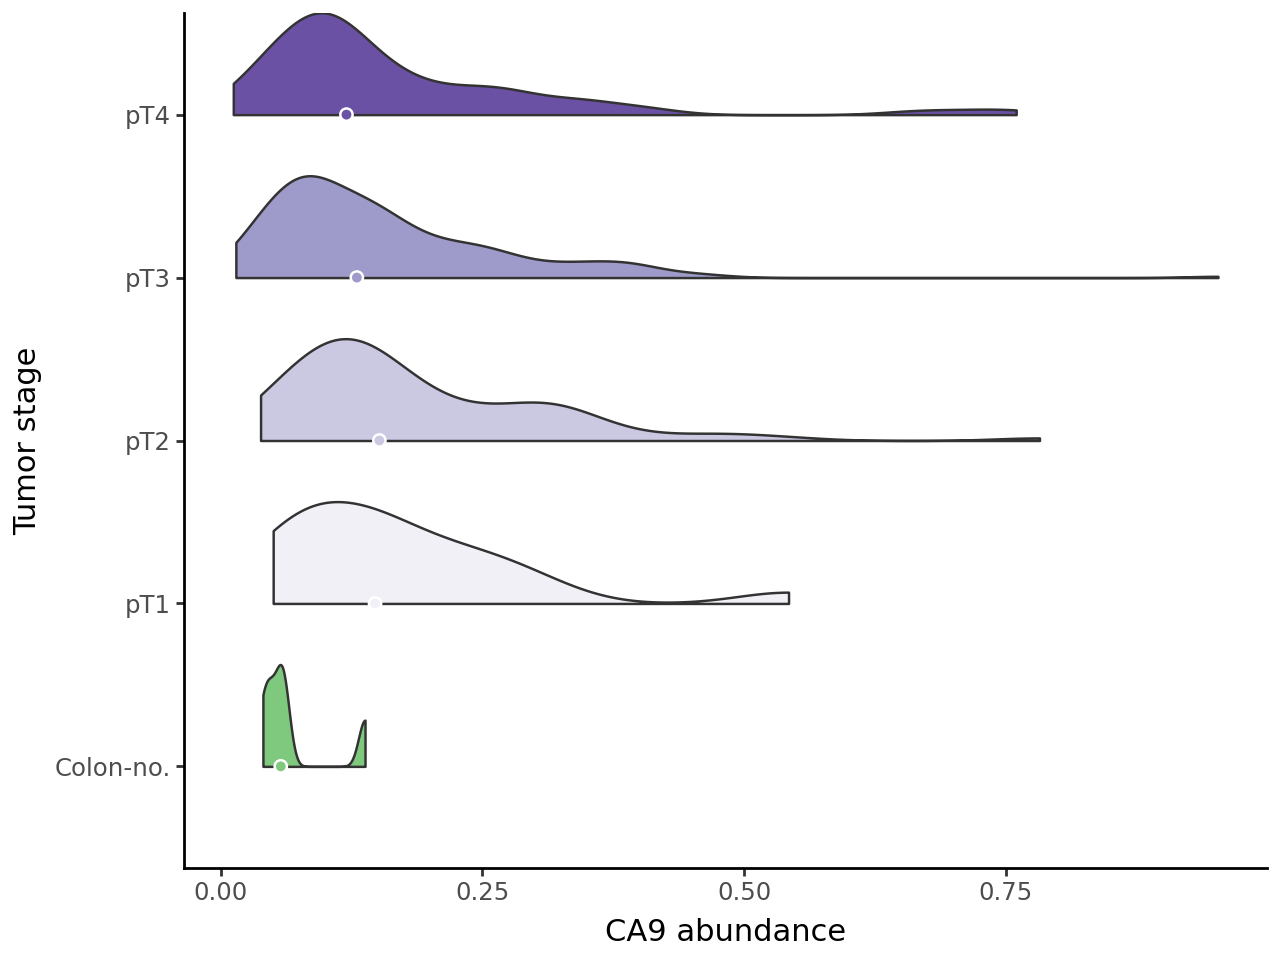

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_CD98_stage.pdf


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


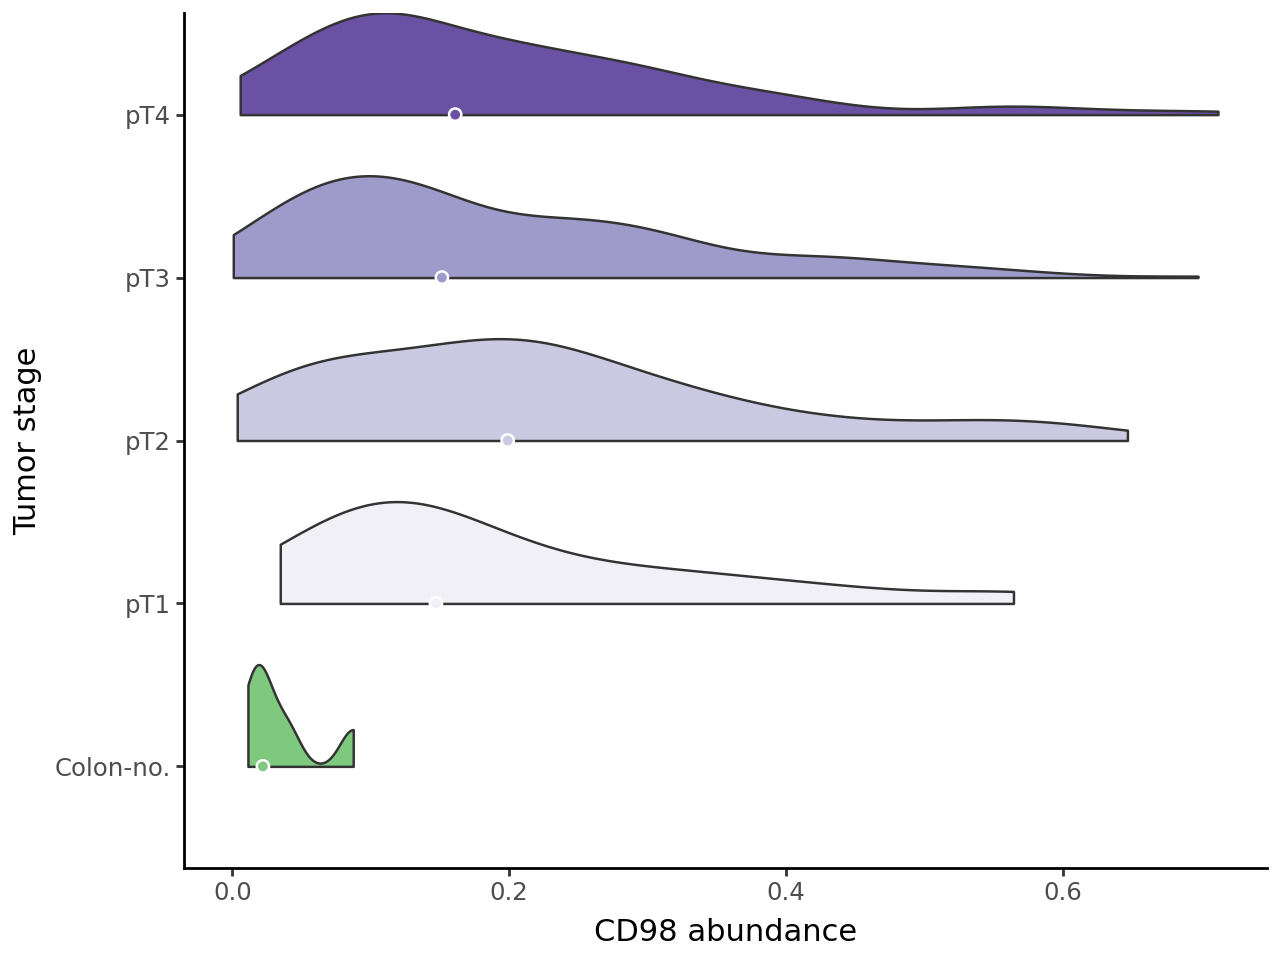

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_CytC_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


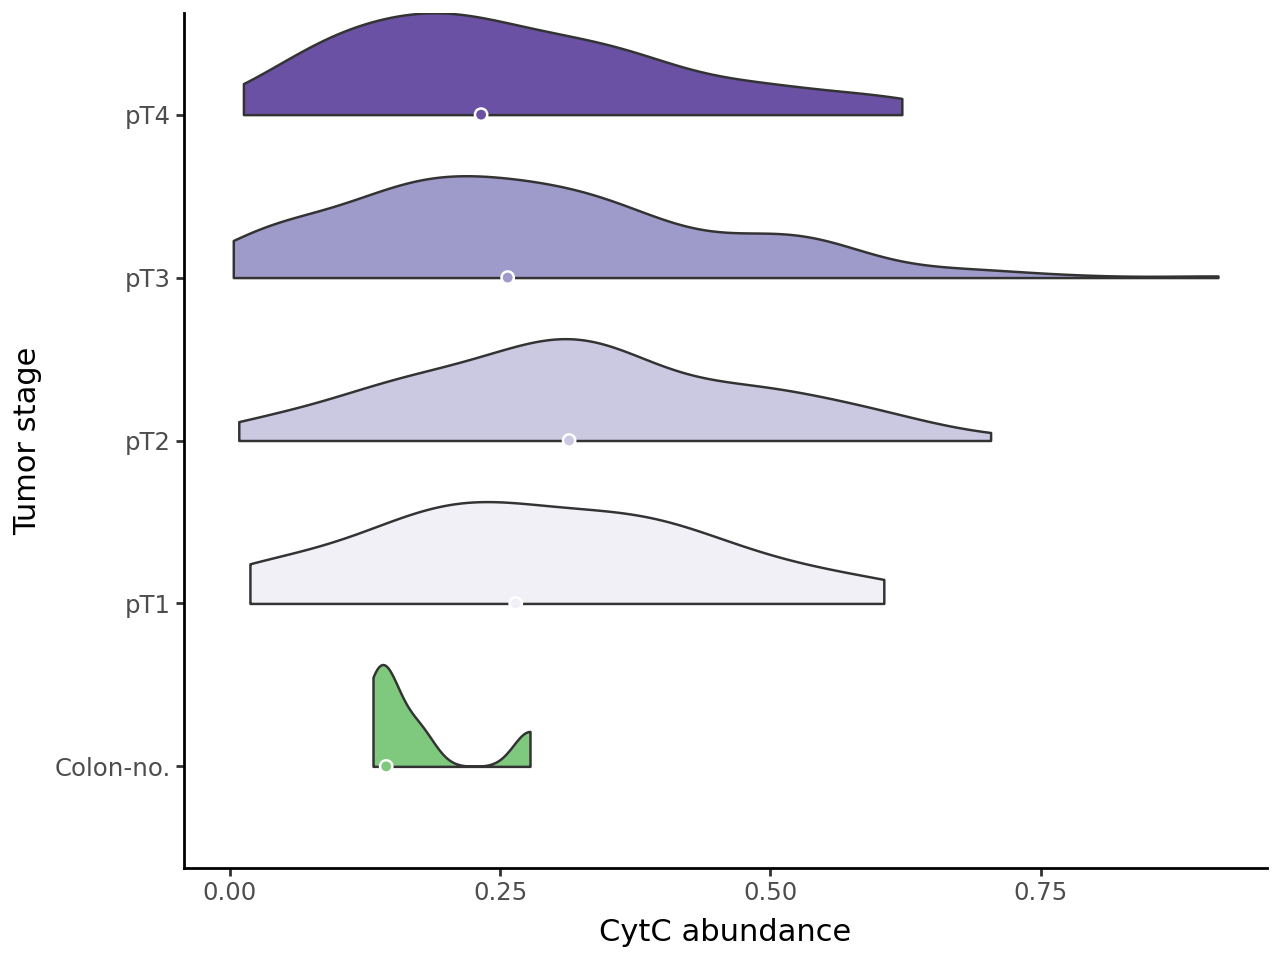

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_MCT1_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


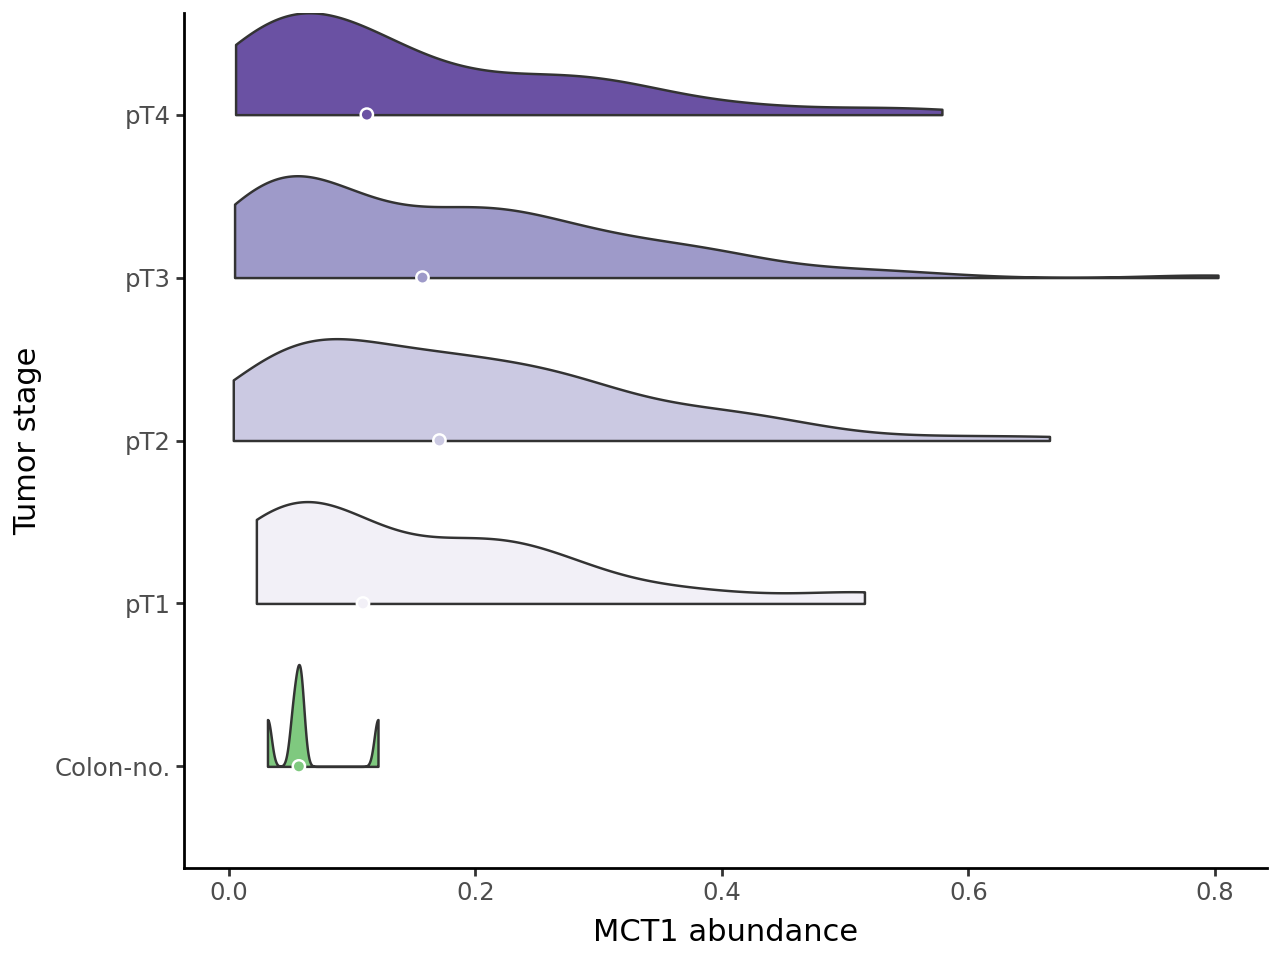

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_ASCT2_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


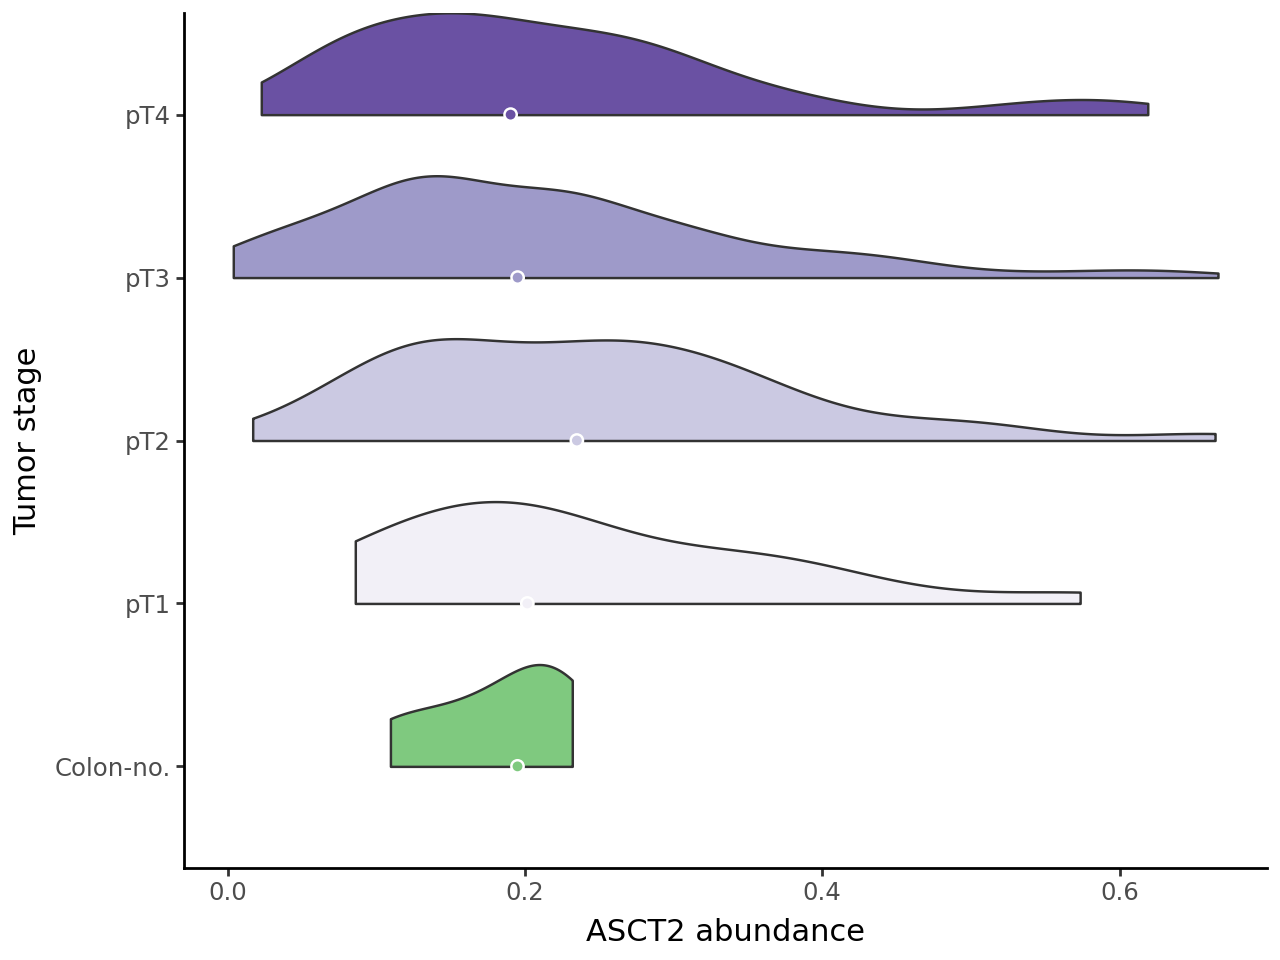

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_LDH_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


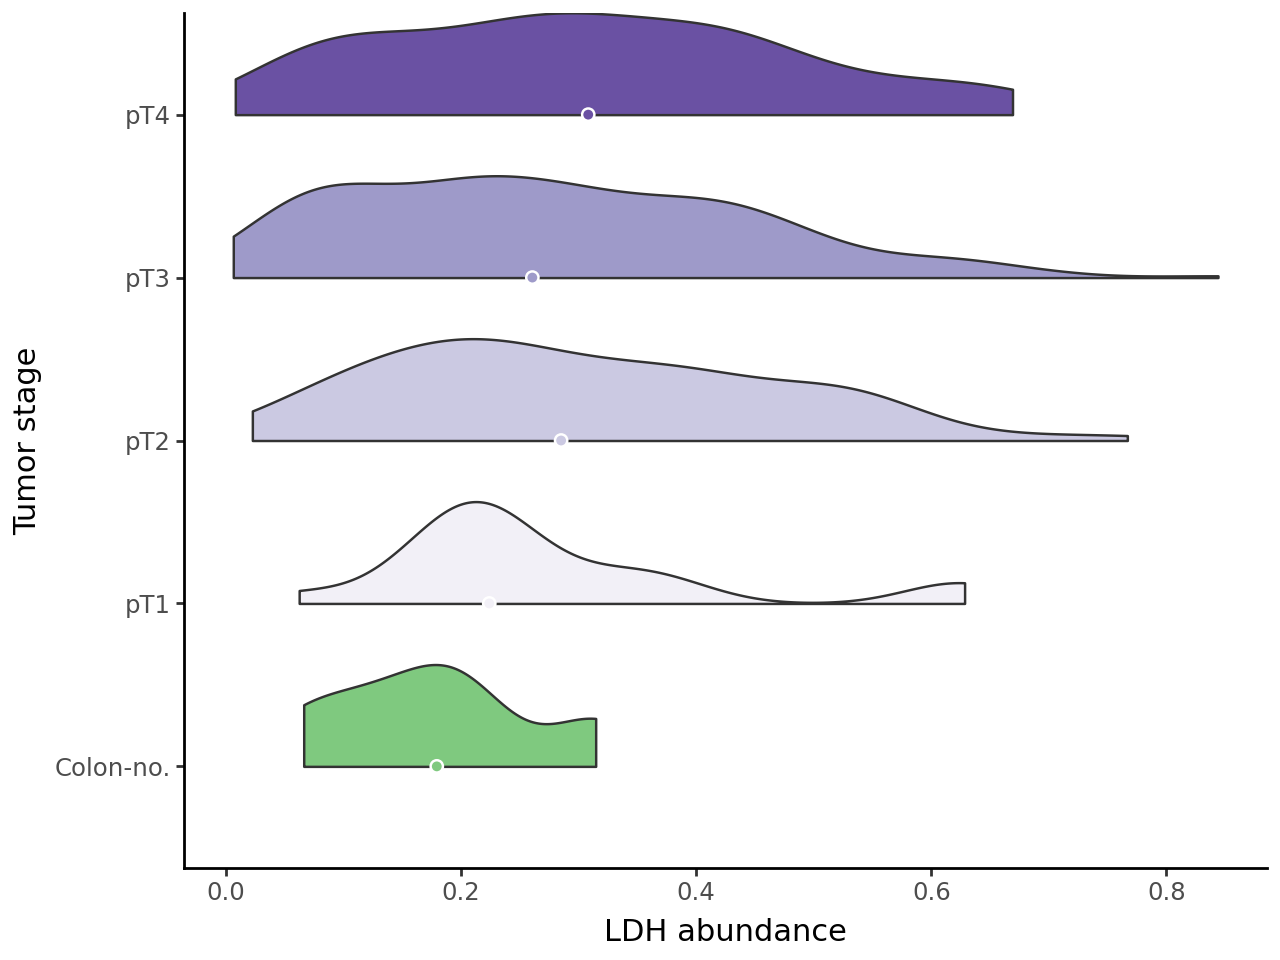

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_GS_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


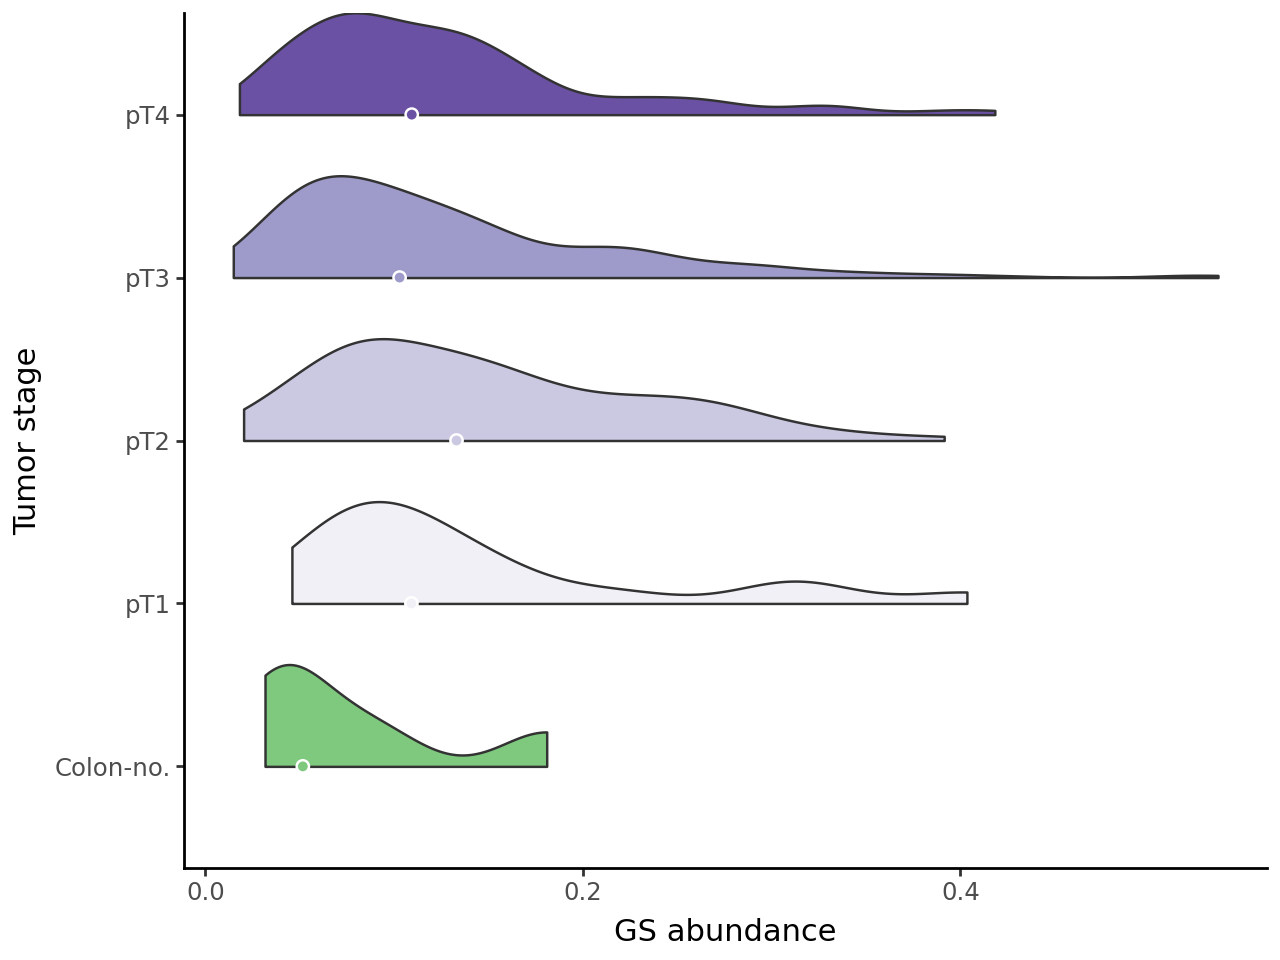

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_GLS_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


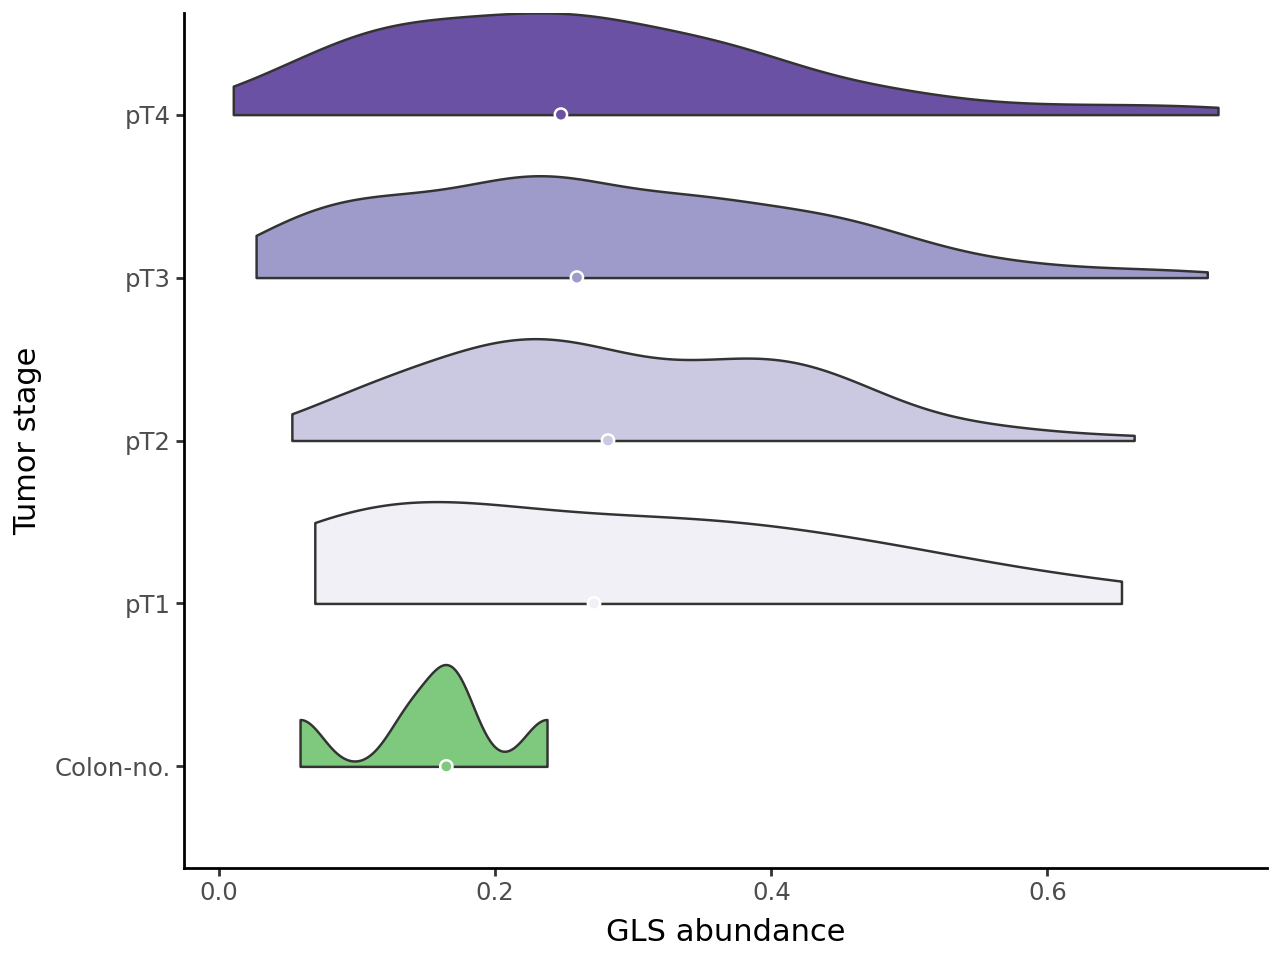

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_ATP5A_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


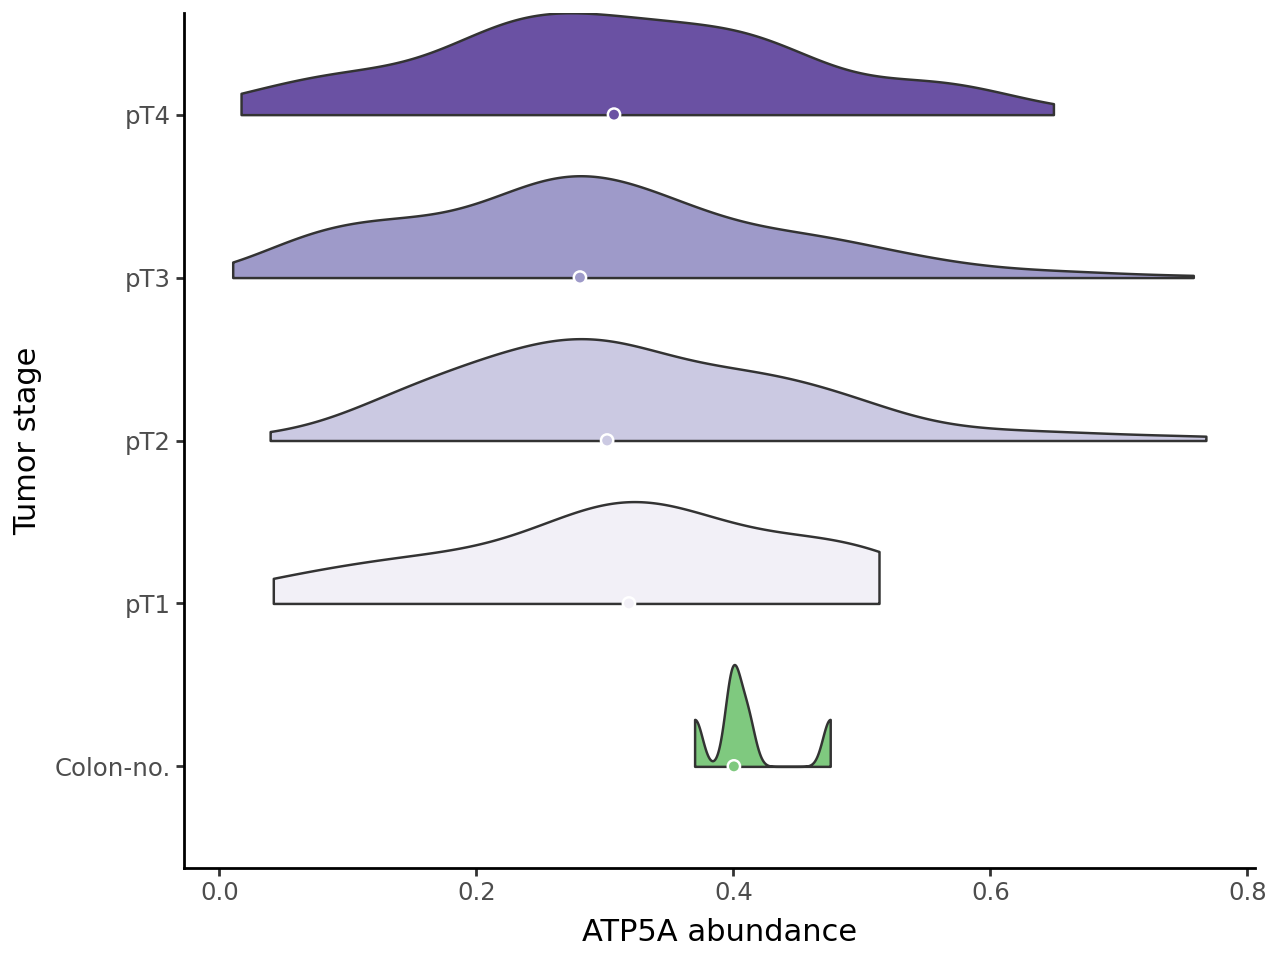

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_CS_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


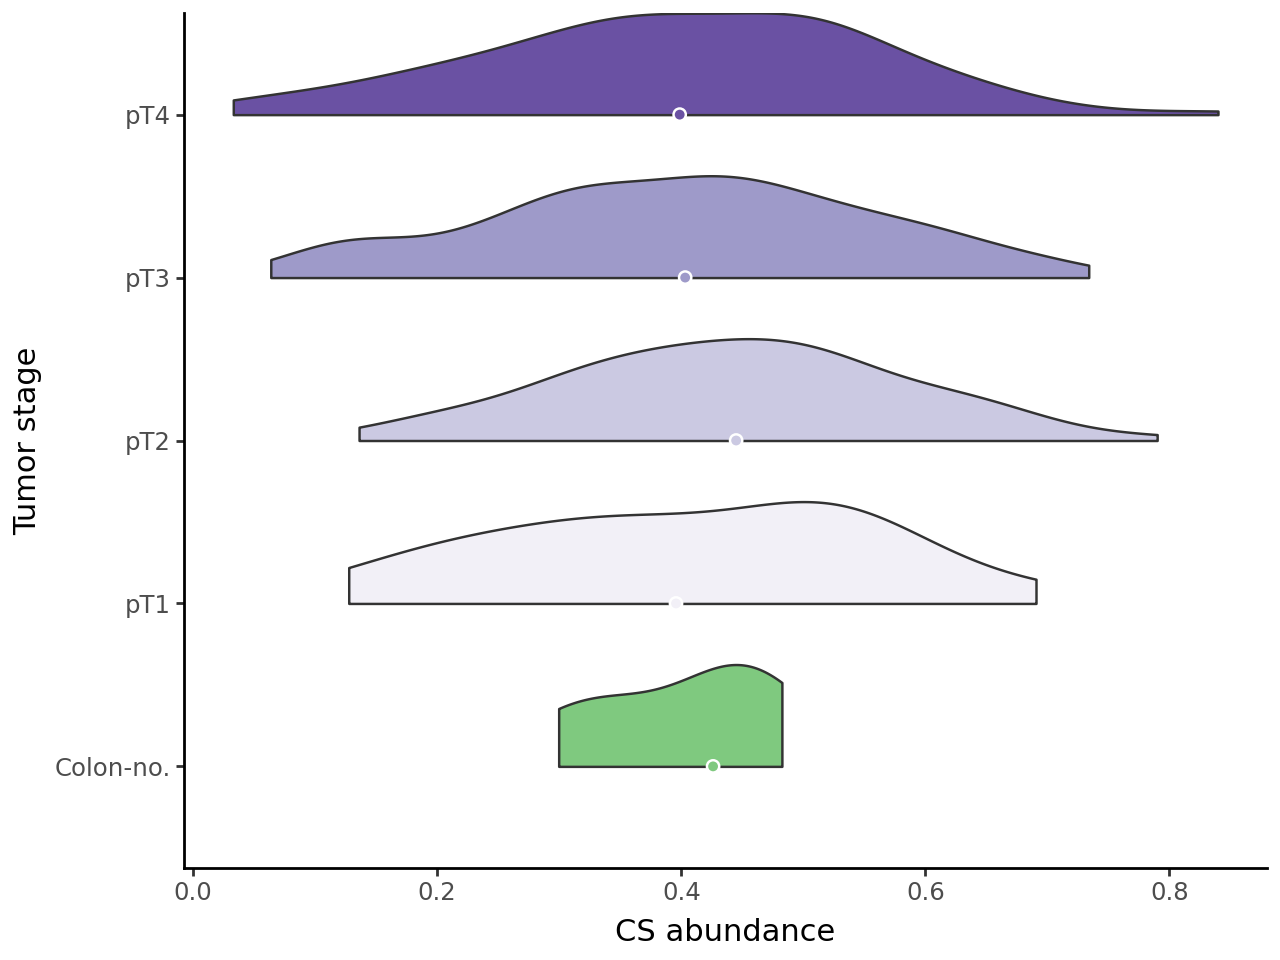

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_PKM2_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


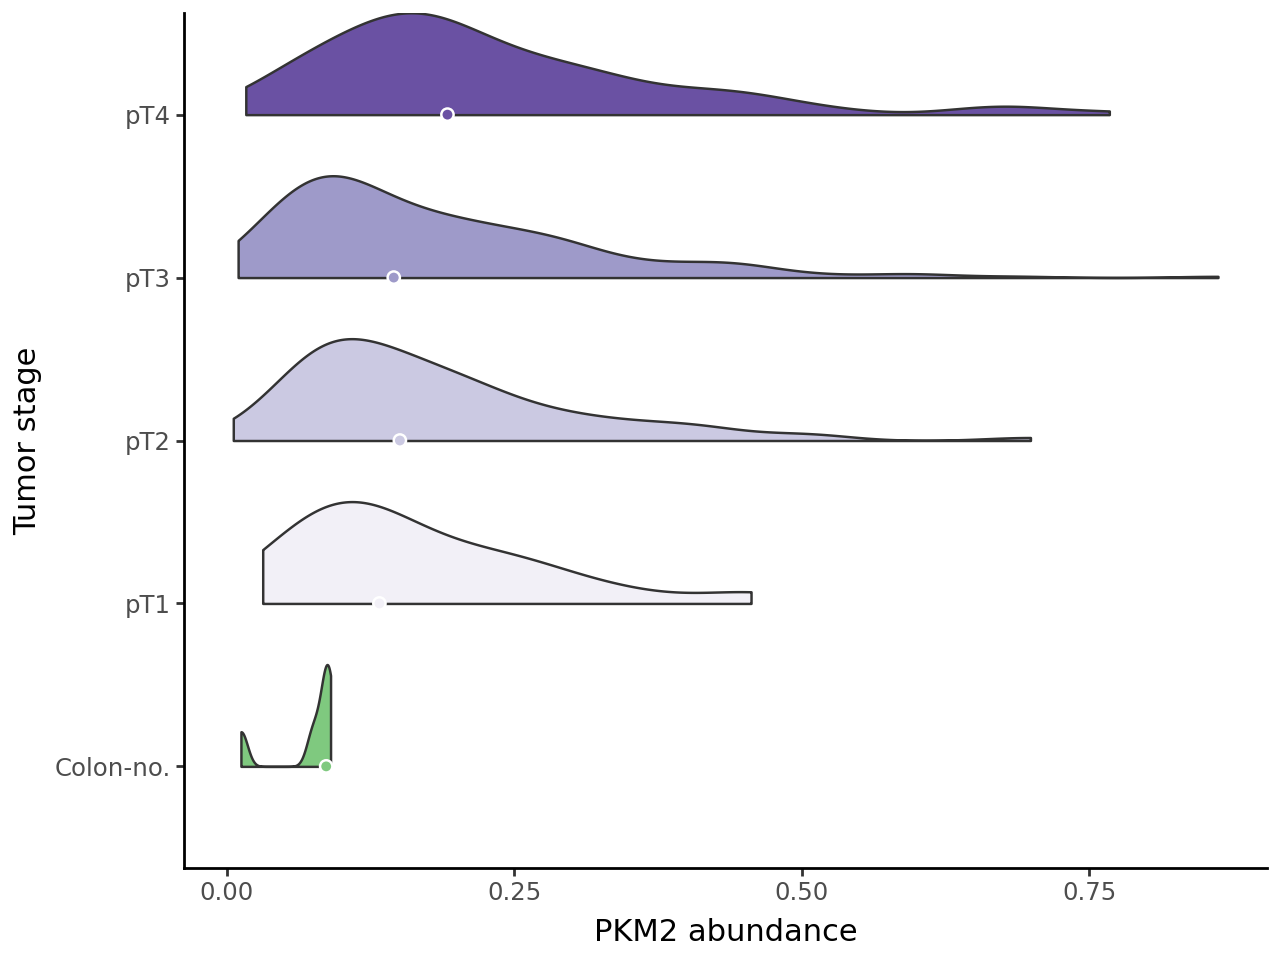

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_GLUT1_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


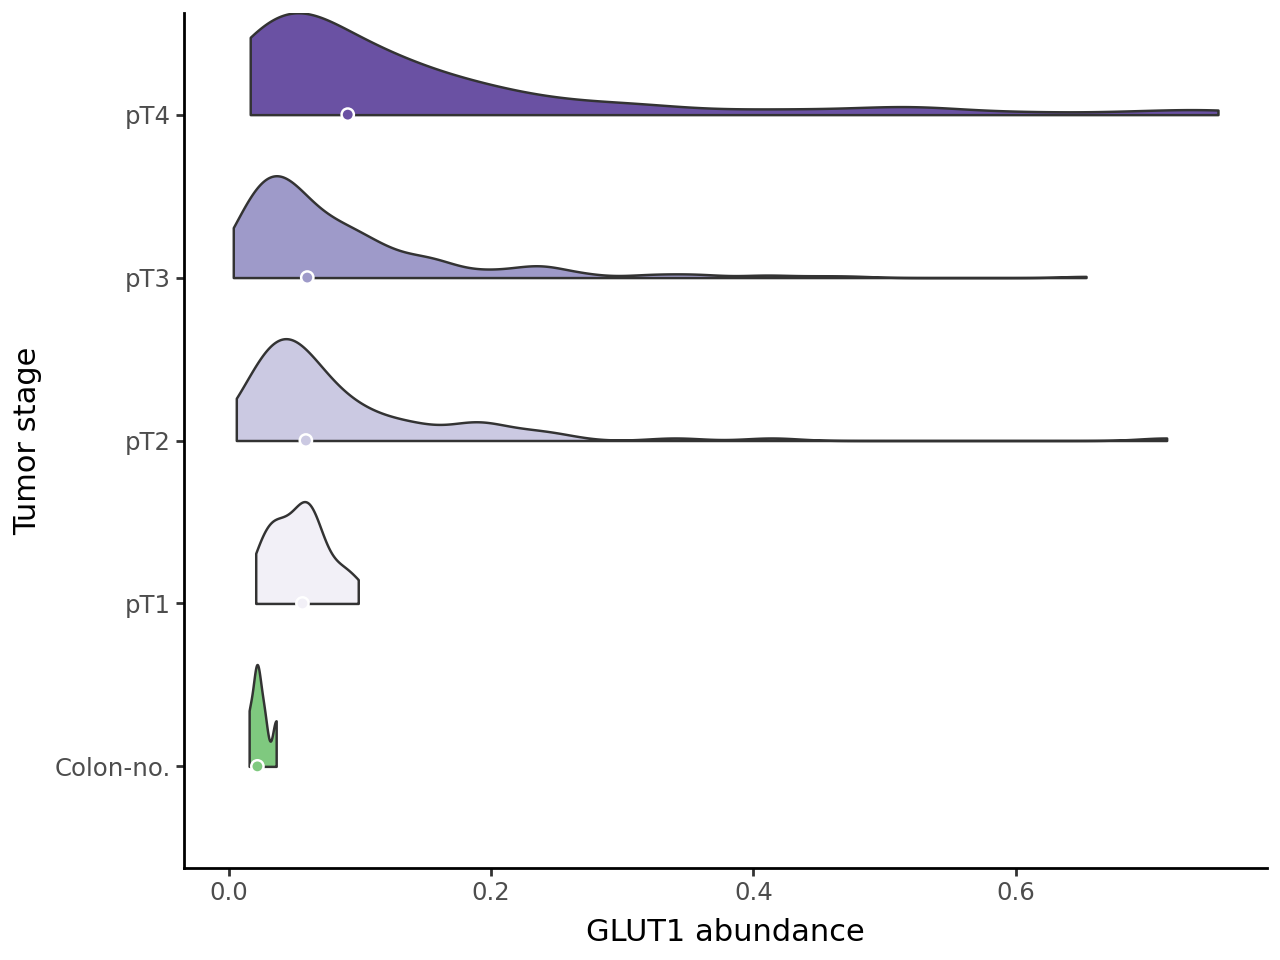

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_ARG1_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


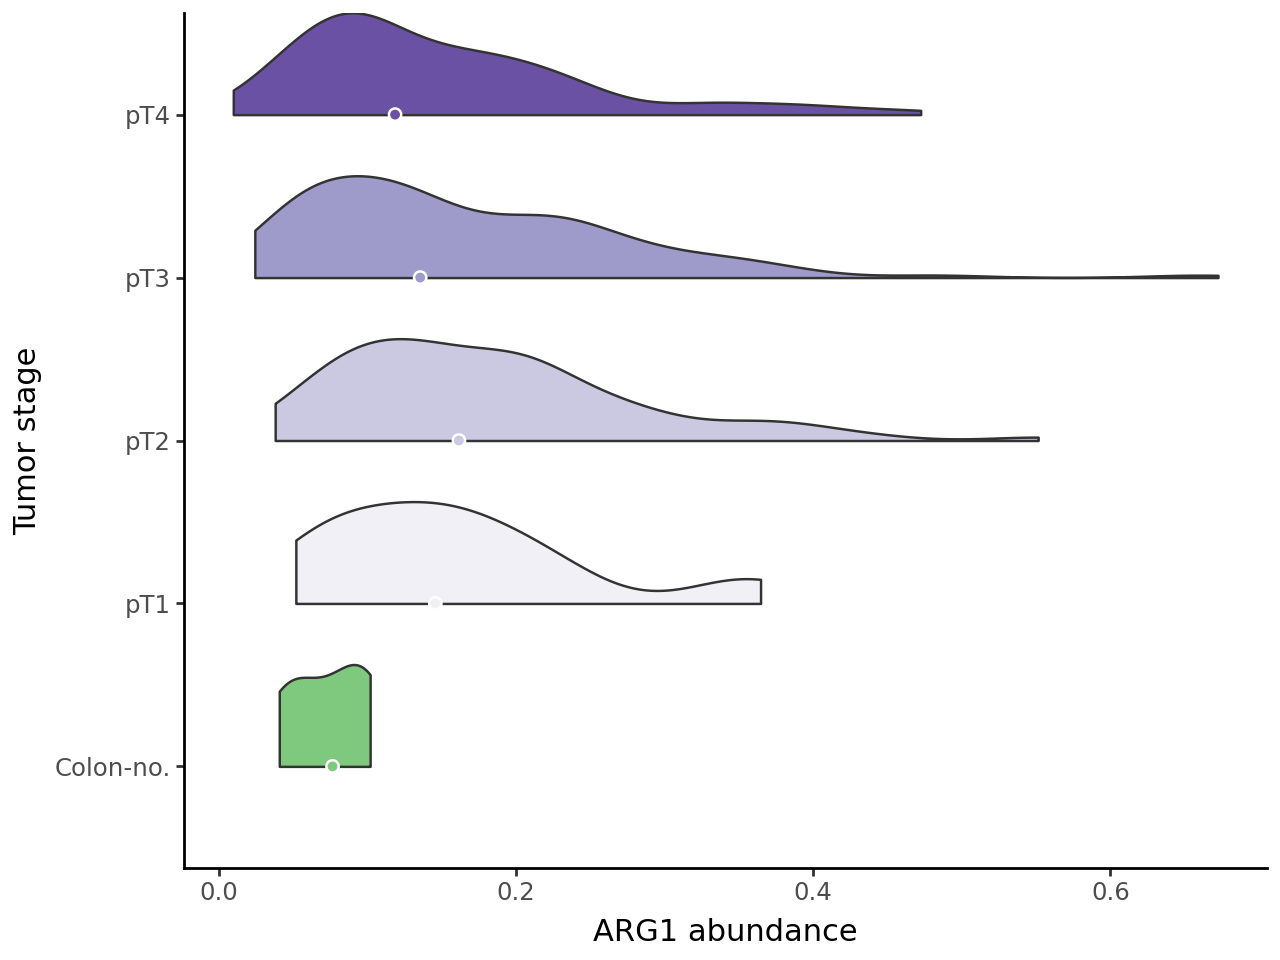

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_CPT1A_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


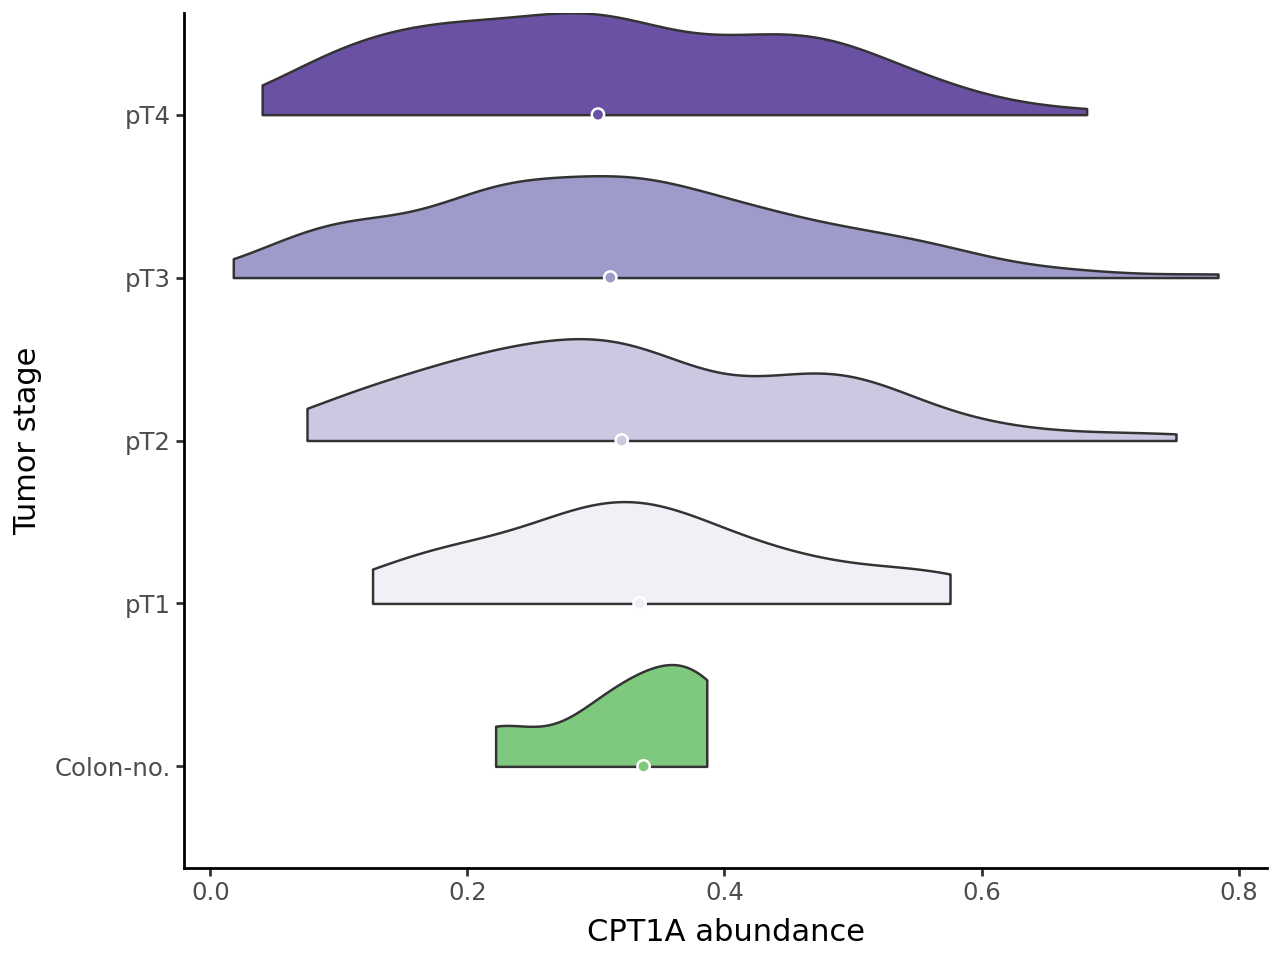

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_Ki67_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


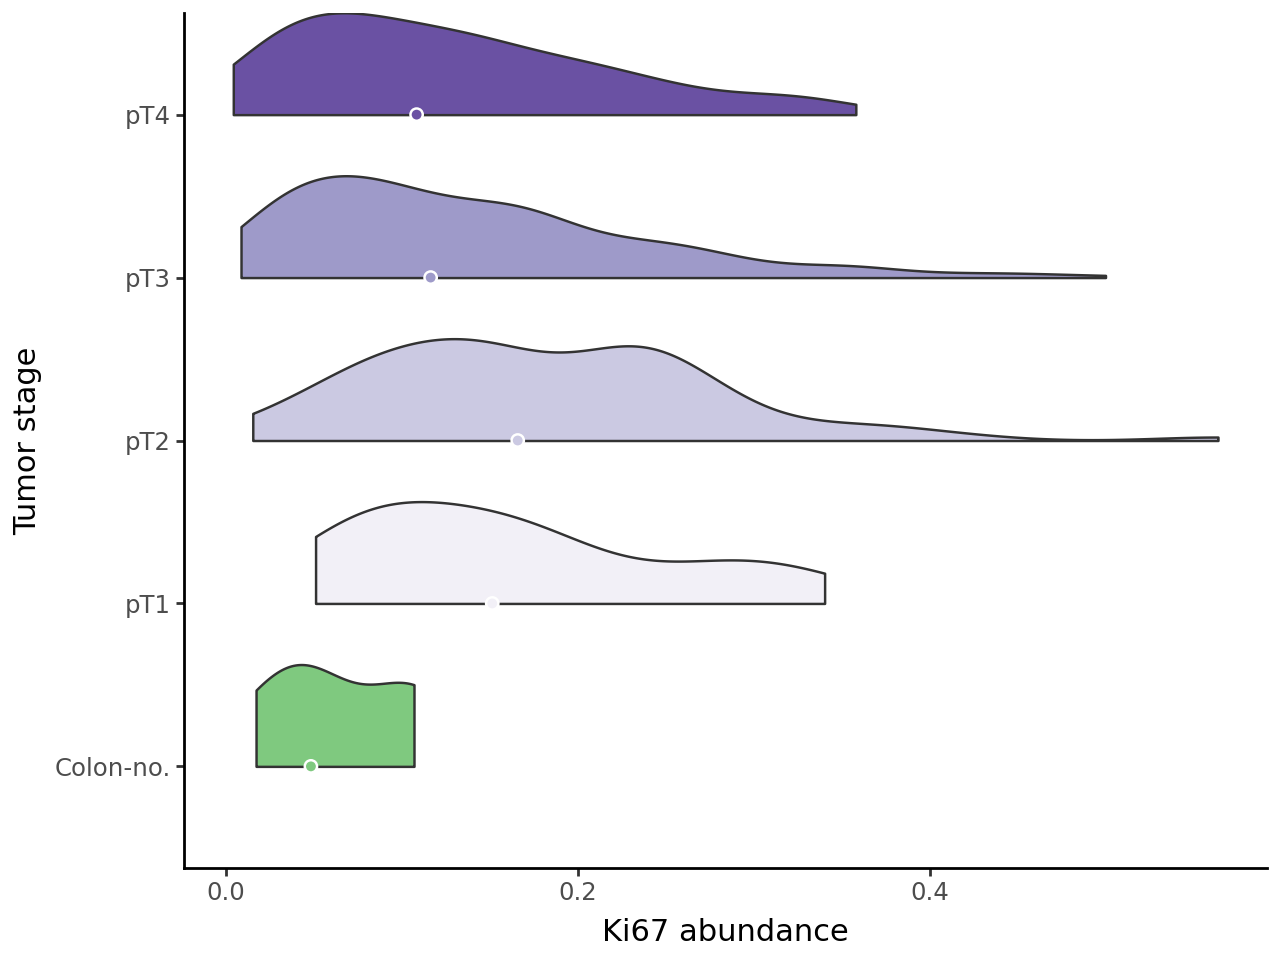

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_STING1_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


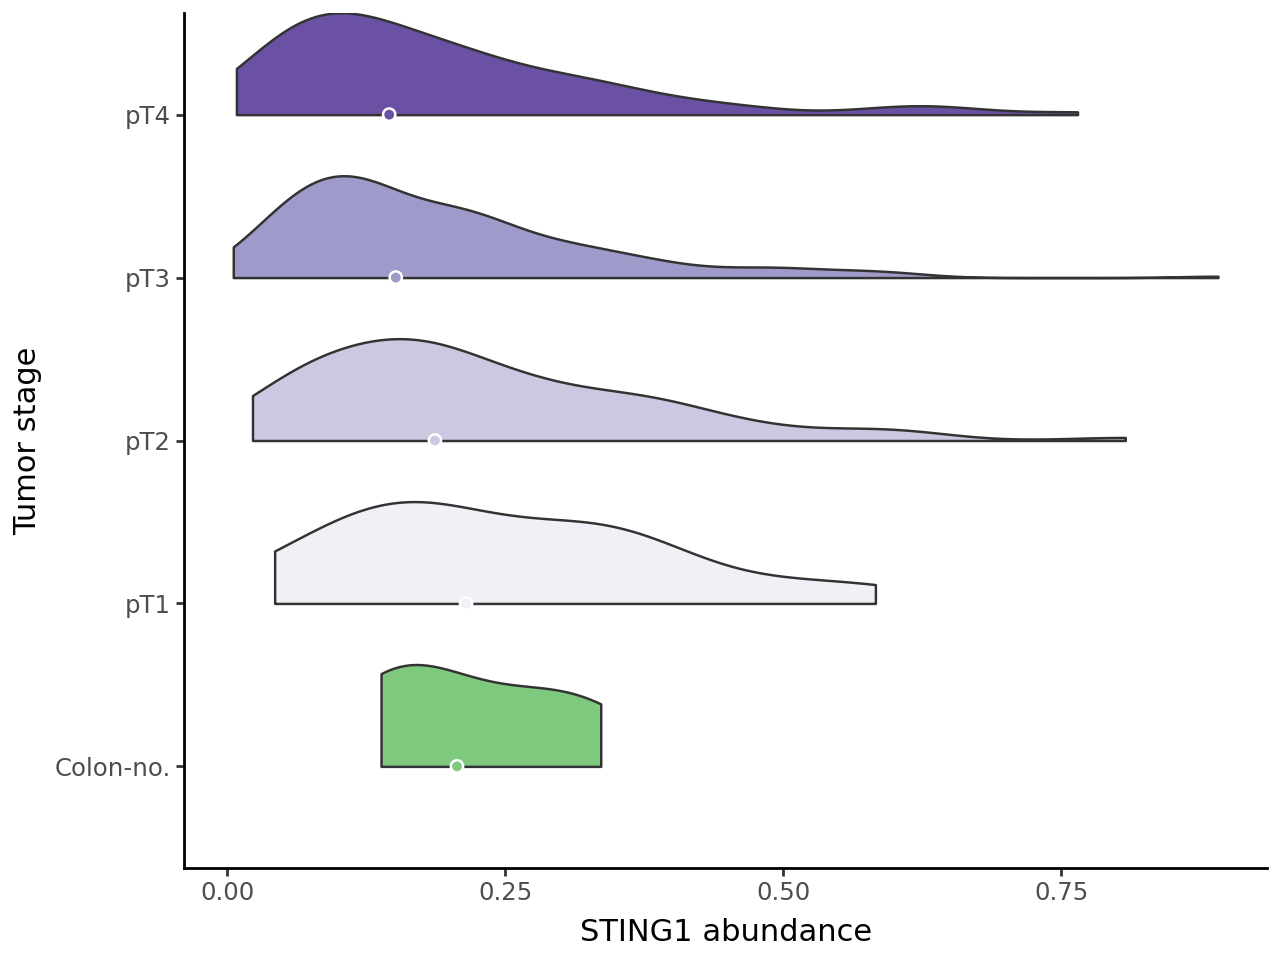

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_MSH2_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


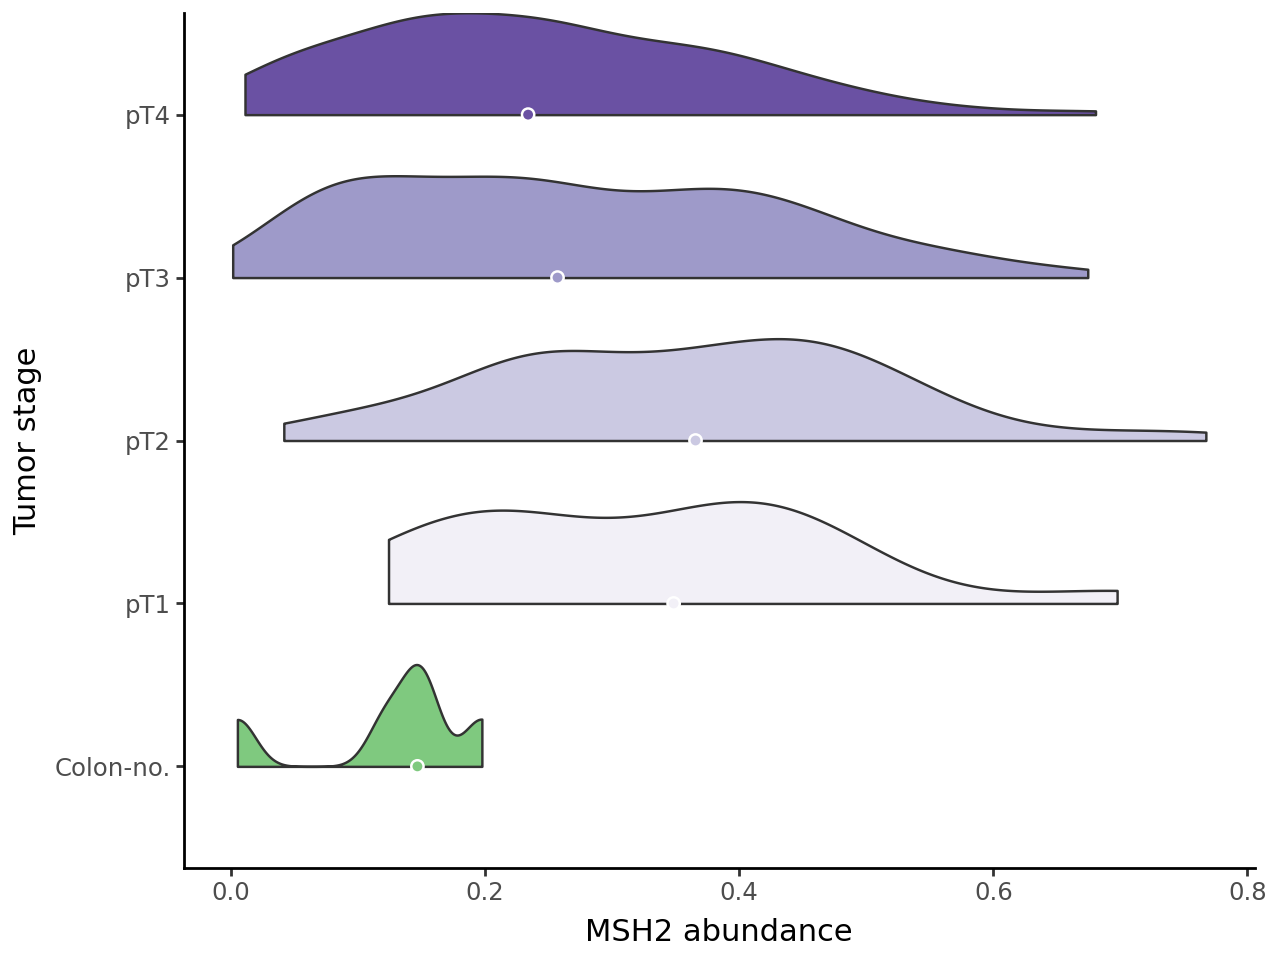

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_MSH6_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


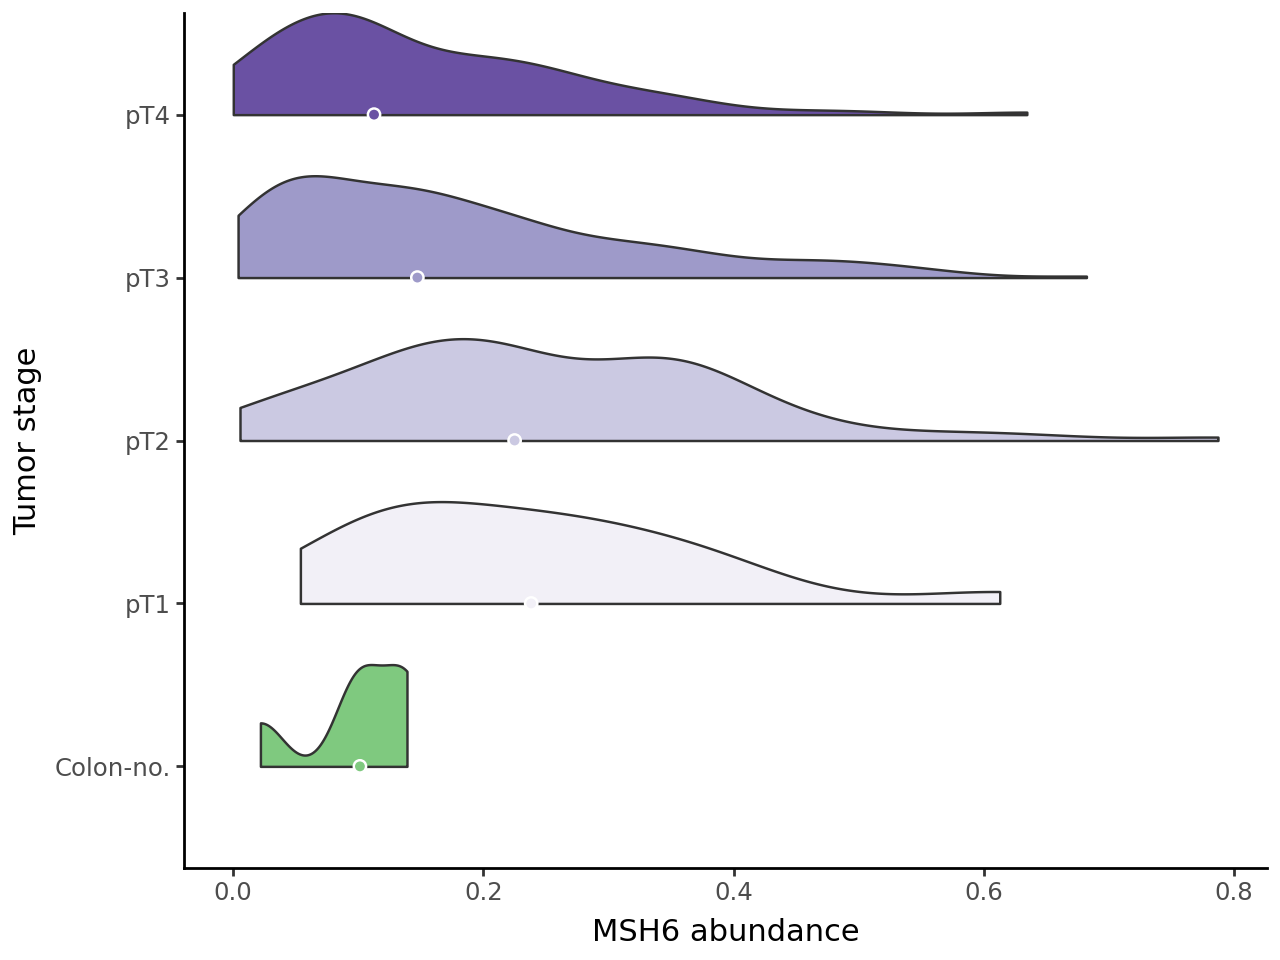

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 3.5 x 3.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/violin_PDL1_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/tmp/ipykernel_359020/1998237618.py:25: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


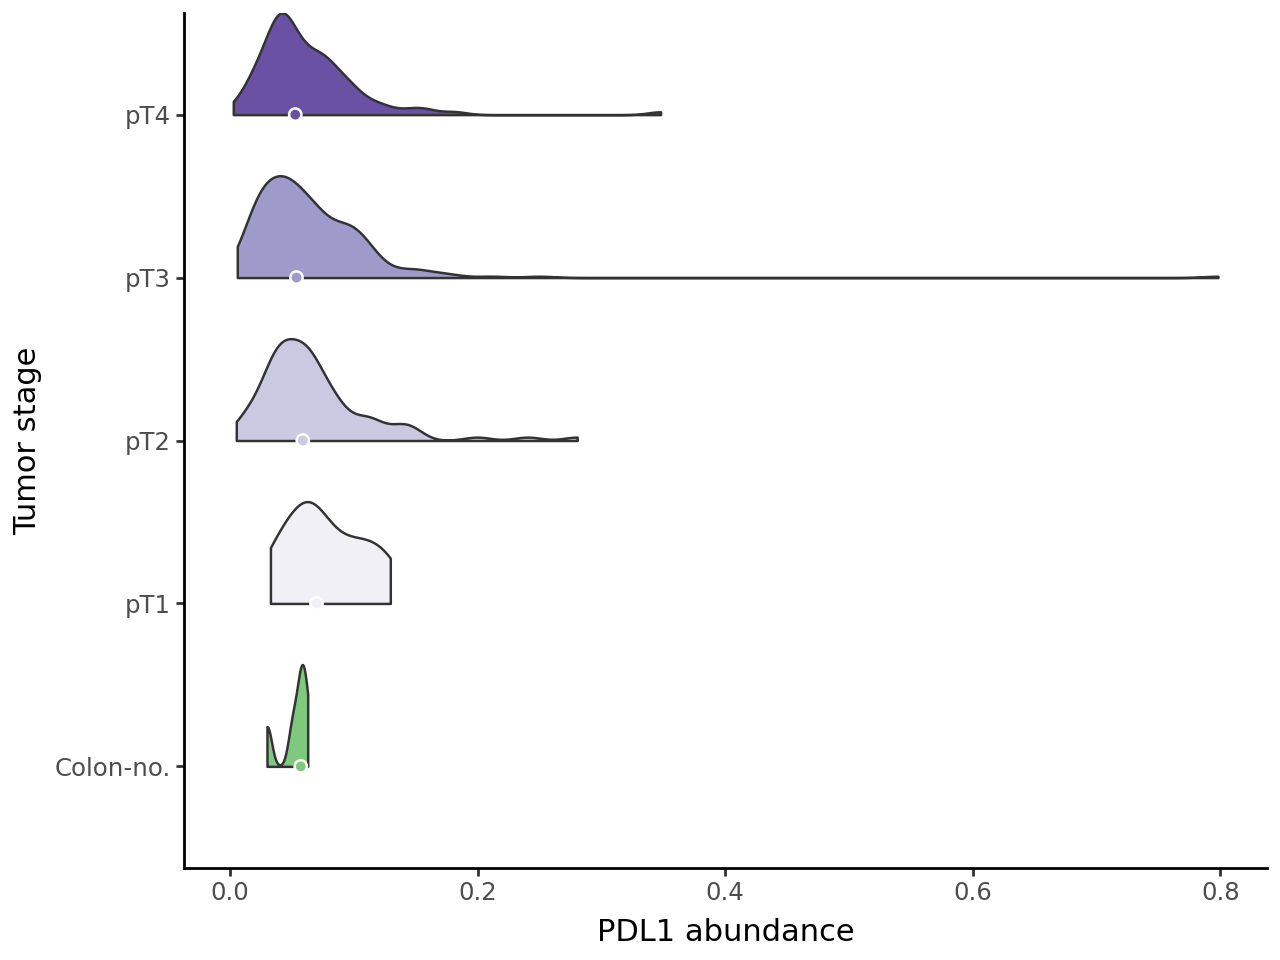

In [22]:
# For visualization only (includes all samples)
metab_per_stage = df.copy()
metab_per_stage["fov"] = meta["fov"] 
metab_per_stage = metab_per_stage.loc[epithelial_subset].groupby("fov").mean()
metab_per_stage = metab_per_stage.join(meta.groupby("fov").first())

pal_stages = [(127,201,127), (242,240,247), (203,201,226), (158,154,201), (106,81,163)]
# Convert to hex
pal_stages = ['#%02x%02x%02x' % (r, g, b) for r, g, b in pal_stages]

for marker in metab_and_functional:
    gp = (ggplot(metab_per_stage, aes(x="Stage", y=marker, color="Stage")) 
          + geom_violin() + theme_classic() + labs(y=marker) + ggtitle(marker)
    )
    gp = (ggplot(metab_per_stage, aes(x = "Stage", fill = "Stage", y = marker)) 
    + geom_violin(style="right", scale="width", width = 1.25) 
    # Use stat_summary to compute and plot the median for each group
    + stat_summary(fun_y=np.median, geom='point', color='white', size=2)
    + theme_classic() 
    + coord_flip()
    + scale_fill_manual(values = pal_stages)
    + theme(legend_position = "none")
    + labs(y = f"{marker} abundance", x = "Tumor stage"))
    ggsave(gp, f"../../figures/fig3/violin_{marker}_stage.pdf", width = 3.5, height = 3.5)
    print(gp)


### Score 1: keep all markers separated

In [23]:

# Only metabolic markers for cancer/epithelial cells
# df = adata.obs.loc[adata.obs.consensus == "Cancer_cell",metab_markers] 
df = adata.obs.loc[(adata.obs.consensus == "Cancer_cell") & (~adata.obs.fov.isin(sparse_epi_fovs)),
                   metab_markers] 
# meta = adata.obs.loc[adata.obs.consensus == "Cancer_cell",["Stage","fov"]]
meta = adata.obs.loc[(adata.obs.consensus == "Cancer_cell") & (~adata.obs.fov.isin(sparse_epi_fovs)),
                   ["Stage","fov"]] 

# Only keep well-annotated stages
epithelial_subset = meta["Stage"].isin(["pT1", "pT2", "pT3", "pT4"]).values

For visualization:
```python
import umap

# Reduce to 2 dimensions with UMAP
umap_metab = umap.UMAP(random_state=42).fit_transform(df)

umap_metab = pd.DataFrame(umap_metab, columns=["UMAP1", "UMAP2"])
umap_metab["stage"] = adata.obs.loc[adata.obs.consensus == "Cancer_cell",'Stage'].values

gp = (ggplot(umap_metab, aes(x="UMAP1", y="UMAP2", color="stage")) 
      + geom_point() + theme_classic()
)
gp

gp = (ggplot(umap_metab, aes(x="UMAP1", y="UMAP2")) 
      + geom_bin2d() + theme_classic()
      + facet_wrap("~stage")
)
gp 
```

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedGroupKFold, StratifiedKFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [25]:
# Define which fovs will be held out for validation (outer loop)
fov_stage_table = meta.loc[epithelial_subset].drop_duplicates().reset_index(drop=True)
fov_inner, fov_val, y_inner, y_val = train_test_split(
    fov_stage_table["fov"], fov_stage_table["Stage"], test_size=0.2, random_state=0, stratify=fov_stage_table["Stage"])
meta["inner"] = meta["fov"].isin(fov_inner)

In [26]:
n_splits = 4

cv_folds = StratifiedGroupKFold(n_splits=n_splits)
for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                  meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                  groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
    # All stages should be present in both train and test
    assert len(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov")["Stage"].first().unique()) == 4
    assert len(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[train].groupby("fov")["Stage"].first().unique()) == 4
    # Print the first test FOVs
    print(meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov").first().index[:5]) 

Index(['A1e', 'A1n', 'A3b', 'A3d', 'A3e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1l', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1d', 'A1i', 'A1k', 'A2a', 'A2d'], dtype='object', name='fov')


In [27]:
cross_val_score(
    XGBClassifier(
        n_estimators=250, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
    LabelEncoder().fit_transform(meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"]),
    groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"], 
    cv=cv_folds, 
    scoring='f1_macro')

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:41:23] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



array([0.24052244, 0.25562628, 0.26094669, 0.23319986])

In [28]:
df_per_fov = df.copy()
df_per_fov["fov"] = meta["fov"] 
df_per_fov = df_per_fov.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]].groupby("fov").mean()

In [29]:
meta_per_fov = meta.loc[epithelial_subset].groupby("fov").first()

In [30]:
def conv_traintest_cells_to_fov():
    for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                    meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                    groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
        test_fovs = meta.loc[epithelial_subset].loc[meta["inner"]].iloc[test].groupby("fov").first().index
        train_fovs = meta.loc[epithelial_subset].loc[meta["inner"]].iloc[train].groupby("fov").first().index
        test_fovs_ind = np.where(meta_per_fov.loc[meta_per_fov["inner"]].index.isin(test_fovs))[0]
        train_fovs_ind = np.where(meta_per_fov.loc[meta_per_fov["inner"]].index.isin(train_fovs))[0]
        yield (train_fovs_ind, test_fovs_ind)

# Should work as the output of `split` method: two arrays of indices
cv_folds_fov = [x for x in conv_traintest_cells_to_fov()]

for train, test in cv_folds_fov:
    # All stages should be present in both train and test
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"].unique()) == 4
    assert len(meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"].unique()) == 4
    # Print the first test FOVs
    print(meta_per_fov.loc[meta_per_fov["inner"]].iloc[test].index[:5])

Index(['A1e', 'A1n', 'A3b', 'A3d', 'A3e'], dtype='object', name='fov')
Index(['A1c', 'A1m', 'A1o', 'A1p', 'A1q'], dtype='object', name='fov')
Index(['A1l', 'A1r', 'A2b', 'A2c', 'A2l'], dtype='object', name='fov')
Index(['A1d', 'A1i', 'A1k', 'A2a', 'A2d'], dtype='object', name='fov')


In [31]:
cross_val_score(
    XGBClassifier(
        n_estimators=250, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    df_per_fov,
    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
    cv=cv_folds_fov, 
    scoring='f1_macro')

array([0.24914293, 0.24686914, 0.26751634, 0.3434992 ])

In [32]:
for train, test in cv_folds.split(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]],
                                  meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"],
                                  groups=meta.loc[epithelial_subset].loc[meta["inner"]]["fov"]):
    xgb = XGBClassifier(
        n_estimators=250, 
        max_depth=3, 
        device="cuda", 
        random_state=0)
    xgb.fit(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]].iloc[train],
            LabelEncoder().fit_transform(meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"].iloc[train]),
    )
    # First show f1_score on test data
    preds = xgb.predict(df.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]].iloc[test])
    print(f1_score(LabelEncoder().fit_transform(meta.loc[epithelial_subset].loc[meta["inner"]]["Stage"].iloc[test]), 
                   preds, 
                   average="macro"))
    # This recapitulates the results of calling `cross_val_score`

    # Train on individual cells, test on FOV mean
    test_fov = meta.loc[epithelial_subset].loc[meta["inner"]]["fov"].iloc[test].unique()
    preds = xgb.predict(df_per_fov.loc[test_fov])
    print(f1_score(LabelEncoder().fit_transform(meta.loc[epithelial_subset].loc[meta["inner"]].groupby("fov").first()["Stage"].loc[test_fov]), 
                   preds, 
                   average="macro"))

0.2405224384318766
0.20854555744199207
0.2556262773120096
0.2509392175506134
0.26094669461062203
0.1790470553418171
0.233199860796939
0.23543123543123542


In [33]:
from joblib import Parallel, delayed
import warnings, logging

### Parsimonious model: mean + std abundance per FOV

In [34]:
df_per_fov = df.copy()
df_per_fov["fov"] = meta["fov"] 
df_per_fov = df_per_fov.loc[epithelial_subset].loc[meta.loc[epithelial_subset]["inner"]]
df_per_fov = df_per_fov.groupby("fov").mean().join(df_per_fov.groupby("fov").std(), rsuffix="_std")

In [35]:
def process_fold_intensities(train, test, n_estimators = 250, n_depth = 4):
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    with warnings.catch_warnings(action="ignore"):      
        # Step 1: Define train and test subsets of the compositional data
        train_func = df_per_fov.loc[meta_per_fov["inner"]].iloc[train]
        test_func = df_per_fov.loc[meta_per_fov["inner"]].iloc[test]
        train_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[train]["Stage"]
        test_meta = meta_per_fov.loc[meta_per_fov["inner"]].iloc[test]["Stage"]

        # Step 2: Train a classifier on the training data composition to predict the stage of each FOV
        xgb = XGBClassifier(
            n_estimators=n_estimators, 
            max_depth=n_depth, 
            device="cuda", 
            random_state=0)
        xgb.fit(train_func,
                LabelEncoder().fit_transform(train_meta))

        # Step 3: Predict stage of each FOV in the test data
        preds = xgb.predict(test_func)

        # Step 4: Compute f1_score
        score = f1_score(LabelEncoder().fit_transform(test_meta), 
                        preds, 
                        average="macro")
        return score

In [36]:
def test_estimator_intensities(estimators, depth=4):
    scores = [process_fold_intensities(train, test, n_estimators=estimators, n_depth=depth)
              for train, test in cv_folds_fov]
    mean_score = np.median(scores)
    # Append to f1 score log file
    with open(f"../../data/model2_metab_markers_f1_scores.txt", "a") as f:
        f.write(f"{estimators},{depth},{mean_score}\n")
    
    print(estimators, depth, mean_score)
    return mean_score

In [37]:
cross_val_score(
    XGBClassifier(
        n_estimators=250, 
        max_depth=3, 
        device="cuda", 
        random_state=0),
    df_per_fov,
    LabelEncoder().fit_transform(meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]),
    cv=cv_folds_fov, 
    scoring='f1_macro')

array([0.25790661, 0.28573271, 0.32926094, 0.20584891])

In [ ]:
# Parallelize the hyperparameter loop | ~30mn
np.random.seed(0)
estimator_range = np.arange(15, 511, 10)
depth_range = np.arange(3, 10, 2)
estimator_range, depth_range = np.meshgrid(estimator_range, depth_range)
Parallel(n_jobs=28)(delayed(test_estimator_intensities)(r_estimators, r_depth)
                for r_estimators, r_depth in zip(estimator_range.ravel(), depth_range.ravel()))

In [38]:
pd.read_csv("../../data/model2_metab_markers_f1_scores.txt", names = ["estimators", "depth", "score"]).sort_values("score", ascending=False).head(10)

estimators  depth     score
0           15      3  0.287336
33         305      3  0.275632
24         255      3  0.274708
26         265      3  0.272072
21         225      3  0.271949
20         215      3  0.271949
16         175      3  0.271719
22         235      3  0.271641
37         325      3  0.270650
35         315      3  0.270650

In [39]:
scores = [process_fold_intensities(train, test, n_estimators=15, n_depth=3)
              for train, test in cv_folds_fov]
print(np.median(scores))

0.2873355500237963


In [40]:
np.std(scores)

0.03582620124389779

### Characterize best solution

```
The Shapley value is the average contribution of a feature value to the prediction in different coalitions. The Shapley value is NOT the difference in prediction when we would remove the feature from the model.
```
Note: it could be more appropriate to use a custom `explainer` to rely on marginal distributions rather than conditional distributions (default for xgboost).

In [41]:
estimators = 15
depth = 3

[[ 10   1   3   0]
 [  0  51  16   1]
 [  0   0 173   1]
 [  0   0  20  58]]


/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 7 x 5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/metab_importance_correctly_predicted_samples.pdf


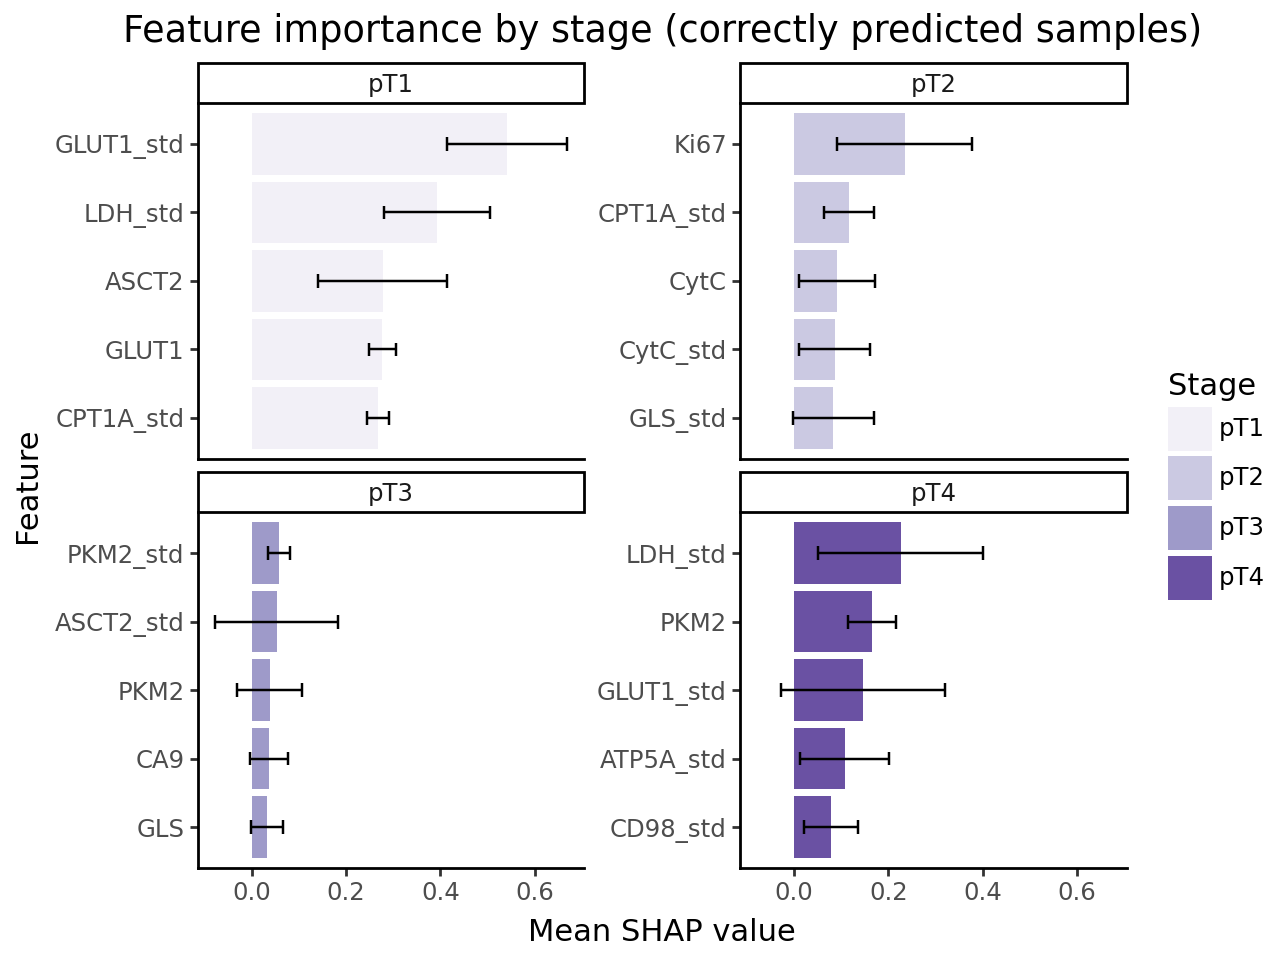

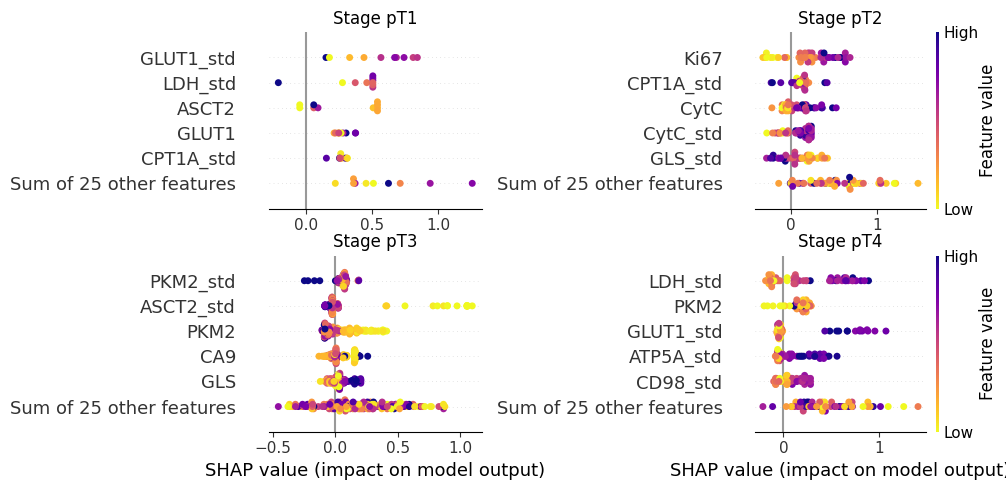

In [42]:
FT_PER_CLASS = 5 # Number of most important features kept per class

# Step 1: Define train and test subsets of the compositional data
train_fov = df_per_fov.loc[meta_per_fov["inner"]]
original_stages = meta_per_fov.loc[meta_per_fov["inner"]]["Stage"]
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(original_stages)

# Step 2: Train a classifier on the training data composition to predict the stage of each FOV
xgb = XGBClassifier(
    n_estimators=estimators, 
    max_depth=depth, 
    device="cuda", 
    random_state=0)
xgb.fit(train_fov,
        true_labels)

explainer = shap.Explainer(xgb)
shap_values = explainer(train_fov)

# Step 3: Generate SHAP values
explainer = shap.Explainer(xgb)
shap_values = explainer(train_fov)

# Purples color palette
pal_stages = [(242,240,247), (203,201,226), (158,154,201), (106,81,163)]
# Convert to hex
pal_stages = ['#%02x%02x%02x' % (r, g, b) for r, g, b in pal_stages]

# Get predictions
predicted_labels = xgb.predict(train_fov)
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Get indices of correctly predicted samples for each class
correct_indices = {class_idx: np.where((true_labels == class_idx) & (predicted_labels == class_idx))[0] 
                   for class_idx in range(conf_matrix.shape[0])}

# Create DataFrame with SHAP values
shap_values_list = []
for class_idx, indices in correct_indices.items():
    shap_values_class = pd.DataFrame(shap_values.values[indices, :, class_idx], 
                                     columns=train_fov.columns)
    shap_values_class['fov'] = train_fov.index[indices]
    shap_values_class['class'] = label_encoder.inverse_transform([class_idx])[0]
    shap_values_list.append(shap_values_class)

shap_values_df = pd.concat(shap_values_list)

# Melt the DataFrame for plotting
shap_values_melted = shap_values_df.melt(id_vars=['fov', 'class'], 
                                        var_name='Feature', 
                                        value_name='SHAP Value')

# Calculate mean and std SHAP values per feature per class
feature_importance = shap_values_melted.groupby(['class', 'Feature'])['SHAP Value'].agg(['mean', 'std']).reset_index()
feature_importance["abs_mean"] = np.abs(feature_importance["mean"])

# Create composite ordered categories per class
composite_data = []
categories_all = []
for class_name, group in feature_importance.groupby('class'):
    # Get top features for this class
    top_features = group.nlargest(FT_PER_CLASS, 'abs_mean').copy()
    # Sort by actual mean value (not absolute) for display order
    top_features = top_features.sort_values('mean', ascending=True)
    # Create composite category
    top_features['Class_Feature'] = top_features['class'] + ":" + top_features['Feature']
    categories_all.extend(top_features['Class_Feature'].tolist())
    composite_data.append(top_features)

# Combine data and assign global ordered categorical
feature_importance = pd.concat(composite_data)
feature_importance['Class_Feature'] = pd.Categorical(
    feature_importance['Class_Feature'],
    categories=categories_all,
    ordered=True
)

# Create bar plot
gp = (ggplot(feature_importance, 
        aes(x='Class_Feature', y='mean', fill='class'))
    + geom_bar(stat='identity')
    + geom_errorbar(aes(ymin='mean-0.5*std', ymax='mean+0.5*std'), 
                    width=0.2)
    + coord_flip()
    + theme_classic()
    + scale_fill_manual(values=pal_stages)
    + scale_x_discrete(labels=dict(zip(feature_importance['Class_Feature'], 
                                     feature_importance['Feature'])))
    + labs(title='Feature importance by stage (correctly predicted samples)', 
           x='Feature', y='Mean SHAP value', fill='Stage')
    + facet_wrap('~class', scales='free_y', ncol=2)
)

ggsave(gp, "../../figures/fig3/metab_importance_correctly_predicted_samples.pdf", width=7, height=5)
gp.show()

# Create beeswarm plots
fig, axes = plt.subplots(2, 2, figsize=(10, 5))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Loop through classes and create SHAP beeswarm plot for each
for class_idx in range(shap_values.shape[2]):
    row = class_idx // 2
    col = class_idx % 2
    plt.sca(axes[row, col])
    
    # Get SHAP values for correctly predicted samples of this class
    class_shap = shap_values[np.where((true_labels == class_idx) & (predicted_labels == class_idx))[0],:,class_idx]

    # Calculate average absolute SHAP values for ordering
    mean_abs_shap = np.abs(class_shap.values.mean(0))
    feature_order = np.argsort(-mean_abs_shap)  # Descending order
    
    # Create beeswarm plot with conditional show_colorbar
    shap.plots.beeswarm(
        class_shap, 
        show=False, 
        color=plt.get_cmap("plasma_r"),
        max_display=FT_PER_CLASS + 1,
        s = 25,
        order=feature_order,
        color_bar=col == 1  # Only show colorbar for right column
    )
    
    plt.title(f'Stage {label_encoder.inverse_transform([class_idx])[0]}')
    
    # Remove x-axis label for top row
    if row == 0:
        plt.xlabel('')

# Adjust figure size and margins
plt.gcf().set_size_inches(10, 5)
plt.tight_layout(w_pad=1.0, h_pad=0.0)

# Save complete figure
plt.savefig("../../figures/fig3/metab_shap_vs_val_correctly_predicted_samples.pdf", 
            bbox_inches='tight')
plt.show()
plt.close()

In [43]:
# Identify example FOVs for each of the most important feature
for ft in feature_importance.Feature.unique():
    print(train_fov.loc[:,ft].sort_values(ascending=False))

fov
B6d    0.393058
D3f    0.302481
B9e    0.281089
A6e    0.269300
A1i    0.246471
         ...   
D4l    0.032584
C2i    0.032457
C1m    0.031267
A3f    0.027865
D6m    0.025619
Name: CPT1A_std, Length: 334, dtype: float64
fov
B7d    0.754231
B6n    0.738696
B8q    0.715114
B6p    0.685388
D4k    0.608155
         ...   
A4o    0.006290
B8e    0.005545
A3f    0.004585
D4l    0.004269
D6m    0.003599
Name: GLUT1, Length: 334, dtype: float64
fov
A4l    0.666201
B8q    0.664238
D8c    0.635005
D4a    0.609326
C2i    0.604130
         ...   
B8e    0.007630
A3f    0.007594
A4o    0.007457
D4l    0.007018
D6m    0.003828
Name: ASCT2, Length: 334, dtype: float64
fov
D9e    0.286065
B5d    0.280106
A2h    0.269982
D8g    0.254117
C5e    0.251086
         ...   
A3f    0.023965
A3h    0.022955
A4b    0.015883
B8e    0.015870
A4k    0.014056
Name: LDH_std, Length: 334, dtype: float64
fov
D3f    0.348671
B6d    0.337791
B8q    0.298278
D9e    0.266725
B6n    0.256064
         ...   
B8e    0.0

## Visualize correlation between markers

In [44]:
# df = cancer cells, non sparse FOVs
corr_df = df.loc[:,~df.columns.isin(['CA9','Ki67'])].corr('spearman')

# Perform hierarchical clustering
row_linkage = linkage(corr_df, method='complete')
col_linkage = linkage(corr_df.T, method='complete')

# Get the order of rows and columns
row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

# Reorder the DataFrame
corr_df = corr_df.iloc[row_order, :].iloc[:, col_order]

# Melt the DataFrame for plotnine
df_melted = corr_df.melt(ignore_index=False).reset_index()

/tmp/ipykernel_359020/1089284016.py:16: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


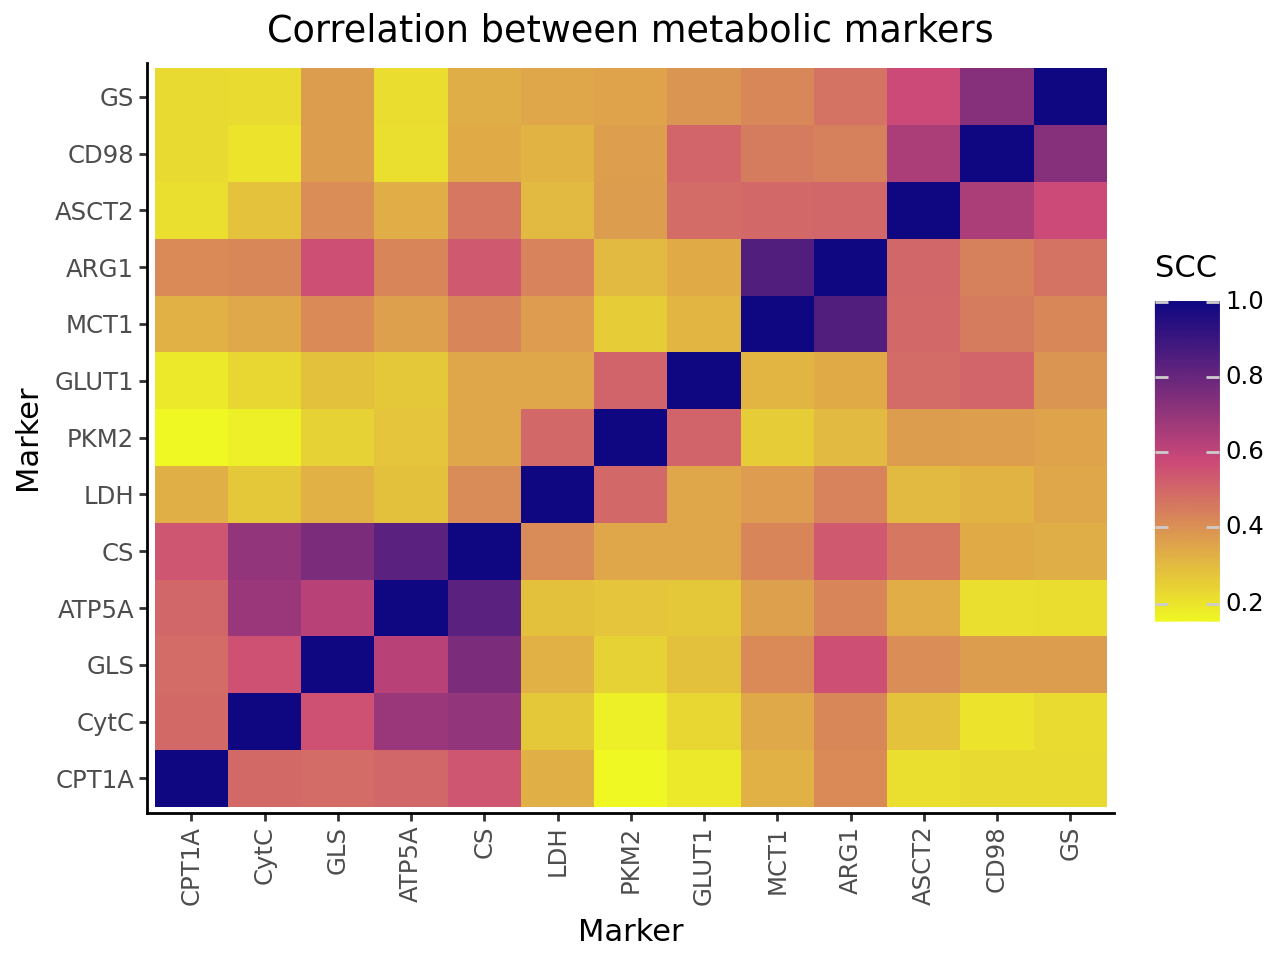

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 4 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/correlation_metab_markers_in_cancer_cells.png
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 4.5 x 4 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/correlation_metab_markers_in_cancer_cells.pdf


In [45]:
# Update the levels of the categorical variables to reflect the new order
df_melted["index"] = pd.Categorical(df_melted["index"], categories=corr_df.index, ordered=True)
df_melted["cell_type"] = pd.Categorical(df_melted["variable"], categories=corr_df.columns.to_list(), ordered=True)

# Display as heatmap
gp = (
    ggplot(df_melted, aes(x="index", y="cell_type")) 
    + geom_tile(aes(fill="value")) 
    + theme_classic() 
    + theme(axis_text_x=element_text(angle=90)) 
    + labs(y="Marker", x="Marker", fill="SCC") 
    # Use reverted plasma color palette
    + scale_fill_gradientn(colors = ["#EFF822", "#CC4977","#0F0782"])
    + ggtitle(f"Correlation between metabolic markers")
)
print(gp)
ggsave(gp, "../../figures/fig3/correlation_metab_markers_in_cancer_cells.png", width = 4.5, height = 4)
ggsave(gp, "../../figures/fig3/correlation_metab_markers_in_cancer_cells.pdf", width = 4.5, height = 4)

## Alternative measure of heterogeneity
Using the entropy of metabolic cluster distributions disregards whether the clusters are similar or distant. We try directly quantifying the variation in metabolic markers in each FOV by using the sum of the coefficient of variations in metabolic marker intensities as a proxy for cellular metabolic heterogeneity per FOV.

In [ ]:
# Compute coefficient of variation per marker (column) grouped by fov
cov_per_fov = (df
               .groupby(meta["fov"])
                .apply(lambda x: x.std() / x.mean())
                .mean(axis = 1)
)
cov_per_fov = cov_per_fov.to_frame("Coefficient of variation")
# Drop NA values (single epithelial cell)
cov_per_fov = cov_per_fov.loc[~cov_per_fov["Coefficient of variation"].isna()]
# Add stage information
cov_per_fov = cov_per_fov.join(adata.obs.loc[:,["fov", "Stage"]].drop_duplicates().set_index("fov"), on="fov")
# Subset to well-annotated stages
cov_per_fov = cov_per_fov.loc[cov_per_fov["Stage"].isin(["Colon-no.", "pT1", "pT2", "pT3", "pT4"])]

In [ ]:
gp = (ggplot(cov_per_fov, aes(x="Stage", y="Coefficient of variation")) +
        geom_violin(aes(fill = "Stage"), style="right", scale="width", width = 1.25) +\
        stat_summary(fun_y=np.median, geom='point', color='white', size=2) +\
        theme_classic() +\
        scale_fill_manual(values=pal_stages) +\
        ylab("Metabolic heterogeneity (mean coefficient of variation)") +\
        scale_y_log10() +\
        coord_flip()
    )
gp.show()
# ggsave(gp, "../../figures/fig3/entropy_metabolic_clusters.pdf", width = 6, height = 5)

In [ ]:
# Compare COV and Ki67 expression

# Get fraction of Ki67-high cells per FOV
df_ki67 = pd.DataFrame(adata[(adata.obs["annotation_consensus"] == "Cancer_cell") &
           (adata.obs["Stage"] != "SCT") &
           (adata.obs["Stage"] != "Colon-no.")].obs)
agg_hi = np.percentile(df_ki67["Ki67"], 80)

ki67 = adata.obs.loc[adata.obs.consensus == "Cancer_cell",["fov", "Ki67"]]
ki67["Ki67hi"] = ki67["Ki67"] > agg_hi

# Get fraction of Ki67-high cells per FOV
cov_per_fov = cov_per_fov.join(ki67.groupby("fov")["Ki67hi"].value_counts(normalize=True).unstack(fill_value=0).drop(False, axis=1), on="fov")
cov_per_fov.rename(columns={True: "Ki67hi"}, inplace=True)

In [ ]:
ggplot(cov_per_fov, aes(x="Coefficient of variation", y="Ki67hi")) +\
    geom_point(aes(color="Stage")) +\
    theme_classic() +\
    scale_color_manual(values=pal_stages) +\
    xlab("Metabolic heterogeneity") +\
    ylab("Fraction of Ki67-high cells") +\
    facet_wrap("~Stage")

## 